# Fun with Conditional Variational Autoencoders

This is a starter kernel to understand the main principles of conditional variational autoencoders. PyTorch will be used for modelling.

### **Please, give this kernel an upvote if it's helpful for you.**

You can find explanation of the vanilla and variational autoencoders in the following notebook:

* [Fun with Variational Autoencoders](https://www.kaggle.com/averkij/variational-autoencoder-and-faces-generation/edit/run/28076587)

In this kernel we will discuss the conditional variation of the autoencoder and build a model, train it and analyse the latent space with t-SNE technique.

![architecture](https://www.mdpi.com/sensors/sensors-19-02528/article_deploy/html/images/sensors-19-02528-g002.png)


# The dataset

We will use the MNIST dataset because it's simple and small. You can fork this notebook and experiment with the dataset you like. Fashion MNIST, etc.

In [43]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [44]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [45]:
batch_size = 128*128*16
learning_rate = 0.005
input_size = 28*28
hidden_size = 12
labels_length = 10

In [46]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [47]:
dataset = MNIST('./data', transform=transform, download=True)
train_data, test_data = data.random_split(dataset, (50000,10000))

train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True,persistent_workers=True)
val_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [48]:
#helper functions
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = matplotlib.cm.binary)
    plt.show()
    
def plot_loss(history):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [49]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size + labels_length, 64),
            #nn.ReLU(True),
            #nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_size))
             
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + labels_length, 64),
            nn.ReLU(True),
            #nn.Linear(64, 128),
            #nn.ReLU(True),
            nn.Linear(64, input_size),
            nn.Tanh())

    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x,labels),dim=1)
        return self.encoder(x)
    
    def decode(self, x, labels):
        x = torch.cat((x,labels),dim=1)
        return self.decoder(x)

    def forward(self, x, labels):
        x = self.encode(x,labels)
        x = self.decode(x,labels)
        return x

In [50]:
model = autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
def fit_epoch(model, train_loader, criterion, optimizer, is_cvae):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)
        optimizer.zero_grad()
        if is_cvae:
            outputs, mu, logvar = model(inputs,labels)
            loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
            loss.backward()
        else:
            outputs = model(inputs,labels)
            loss = criterion(outputs, inputs.view(-1,28*28))
            loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    return train_loss
  
def eval_epoch(model, val_loader, criterion, is_cvae):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    inp,out = [],[]
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        with torch.set_grad_enabled(False):
            if is_cvae:
                outputs, mu, logvar = model(inputs,labels)
                loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
                loss.backward()
            else:
                outputs = model(inputs,labels)
                loss = criterion(outputs, inputs.view(-1,28*28))
                inp,out = inputs, outputs

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
        
    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].cpu(),out[0].cpu()],28,28,1,2)

    val_loss = running_loss / processed_size
    return val_loss
  
def train(train_loader, val_loader, model, epochs, batch_size, is_cvae=False):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:        
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt, is_cvae)
            print("loss", train_loss)            
            val_loss = eval_epoch(model, val_loader, criterion, is_cvae)
            history.append((train_loss, val_loss))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))            
    return history

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

loss 0.9286805987358093


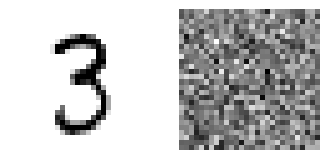

epoch:   0%|          | 1/200 [00:13<44:39, 13.46s/it]


Epoch 001 train_loss: 0.9287 val_loss 0.9115
loss 0.9112299084663391


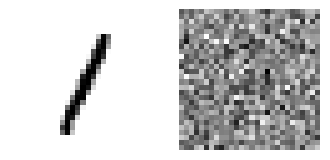

epoch:   1%|          | 2/200 [00:26<43:24, 13.16s/it]


Epoch 002 train_loss: 0.9112 val_loss 0.8922
loss 0.8918585777282715


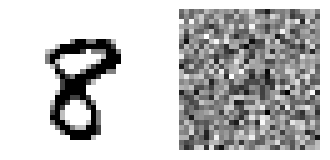

epoch:   2%|▏         | 3/200 [00:38<41:58, 12.78s/it]


Epoch 003 train_loss: 0.8919 val_loss 0.8712
loss 0.8709028363227844


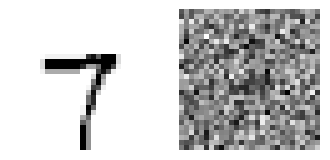

epoch:   2%|▏         | 4/200 [00:50<41:00, 12.56s/it]


Epoch 004 train_loss: 0.8709 val_loss 0.8480
loss 0.8476780652999878


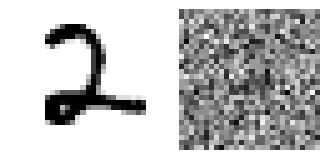

epoch:   2%|▎         | 5/200 [01:03<40:30, 12.46s/it]


Epoch 005 train_loss: 0.8477 val_loss 0.8219
loss 0.821574866771698


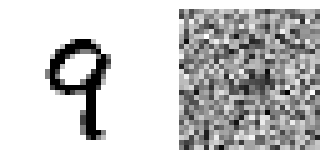

epoch:   3%|▎         | 6/200 [01:15<40:00, 12.38s/it]


Epoch 006 train_loss: 0.8216 val_loss 0.7934
loss 0.7931557893753052


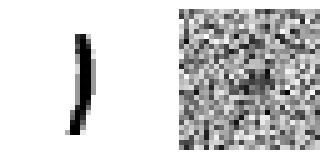

epoch:   4%|▎         | 7/200 [01:27<39:56, 12.42s/it]


Epoch 007 train_loss: 0.7932 val_loss 0.7633
loss 0.7630850076675415


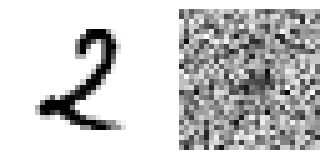

epoch:   4%|▍         | 8/200 [01:40<39:35, 12.37s/it]


Epoch 008 train_loss: 0.7631 val_loss 0.7317
loss 0.7315028309822083


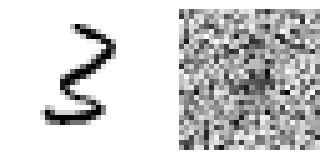

epoch:   4%|▍         | 9/200 [01:52<39:28, 12.40s/it]


Epoch 009 train_loss: 0.7315 val_loss 0.6985
loss 0.698354184627533


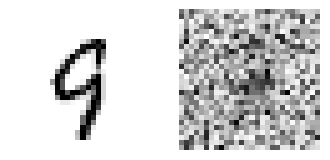

epoch:   5%|▌         | 10/200 [02:05<39:25, 12.45s/it]


Epoch 010 train_loss: 0.6984 val_loss 0.6640
loss 0.663943886756897


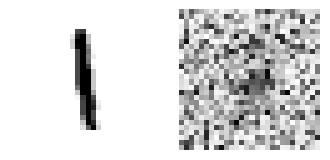

epoch:   6%|▌         | 11/200 [02:17<38:54, 12.35s/it]


Epoch 011 train_loss: 0.6639 val_loss 0.6291
loss 0.6290966272354126


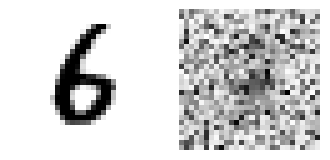

epoch:   6%|▌         | 12/200 [02:29<38:45, 12.37s/it]


Epoch 012 train_loss: 0.6291 val_loss 0.5946
loss 0.5946159362792969


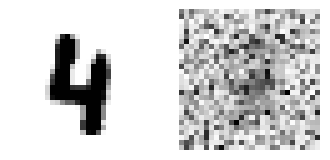

epoch:   6%|▋         | 13/200 [02:42<38:23, 12.32s/it]


Epoch 013 train_loss: 0.5946 val_loss 0.5609
loss 0.5609521865844727


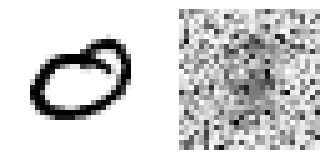

epoch:   7%|▋         | 14/200 [02:54<38:20, 12.37s/it]


Epoch 014 train_loss: 0.5610 val_loss 0.5283
loss 0.5284422636032104


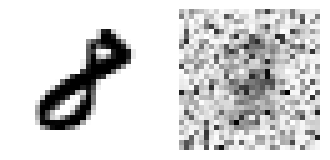

epoch:   8%|▊         | 15/200 [03:06<38:00, 12.33s/it]


Epoch 015 train_loss: 0.5284 val_loss 0.4972
loss 0.4974251091480255


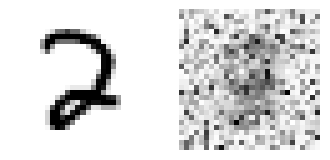

epoch:   8%|▊         | 16/200 [03:18<37:40, 12.29s/it]


Epoch 016 train_loss: 0.4974 val_loss 0.4679
loss 0.4682312607765198


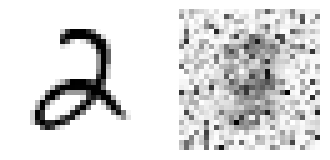

epoch:   8%|▊         | 17/200 [03:31<37:25, 12.27s/it]


Epoch 017 train_loss: 0.4682 val_loss 0.4407
loss 0.4411422312259674


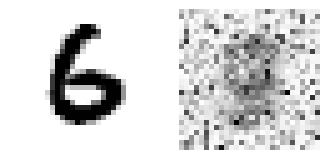

epoch:   9%|▉         | 18/200 [03:43<37:35, 12.39s/it]


Epoch 018 train_loss: 0.4411 val_loss 0.4159
loss 0.41635194420814514


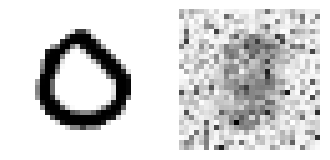

epoch:  10%|▉         | 19/200 [03:56<37:25, 12.40s/it]


Epoch 019 train_loss: 0.4164 val_loss 0.3934
loss 0.3939647972583771


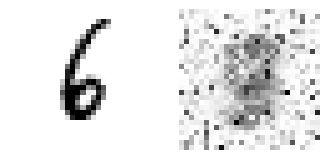

epoch:  10%|█         | 20/200 [04:08<37:06, 12.37s/it]


Epoch 020 train_loss: 0.3940 val_loss 0.3734
loss 0.3740001320838928


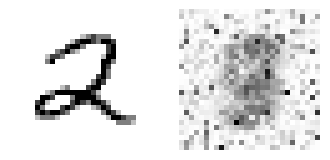

epoch:  10%|█         | 21/200 [04:20<36:48, 12.34s/it]


Epoch 021 train_loss: 0.3740 val_loss 0.3557
loss 0.3563849925994873


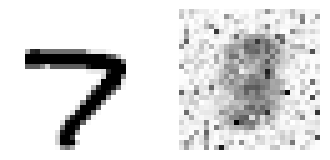

epoch:  11%|█         | 22/200 [04:33<36:30, 12.31s/it]


Epoch 022 train_loss: 0.3564 val_loss 0.3402
loss 0.3409844934940338


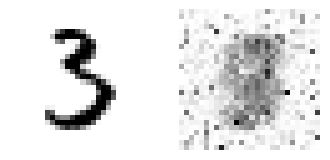

epoch:  12%|█▏        | 23/200 [04:45<36:11, 12.27s/it]


Epoch 023 train_loss: 0.3410 val_loss 0.3268
loss 0.32763782143592834


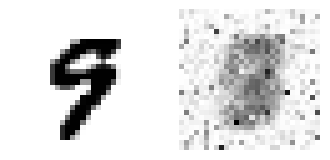

epoch:  12%|█▏        | 24/200 [04:57<36:09, 12.33s/it]


Epoch 024 train_loss: 0.3276 val_loss 0.3154
loss 0.31618714332580566


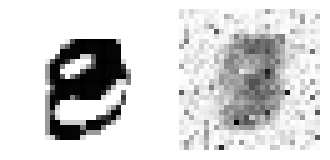

epoch:  12%|█▎        | 25/200 [05:10<36:24, 12.48s/it]


Epoch 025 train_loss: 0.3162 val_loss 0.3056
loss 0.30649468302726746


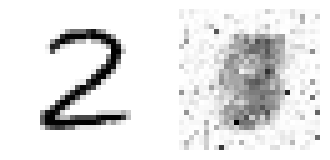

epoch:  13%|█▎        | 26/200 [05:23<36:31, 12.59s/it]


Epoch 026 train_loss: 0.3065 val_loss 0.2975
loss 0.29840460419654846


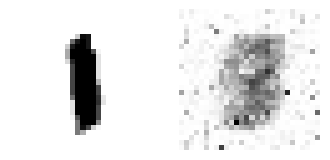

epoch:  14%|█▎        | 27/200 [05:35<36:10, 12.55s/it]


Epoch 027 train_loss: 0.2984 val_loss 0.2908
loss 0.29171526432037354


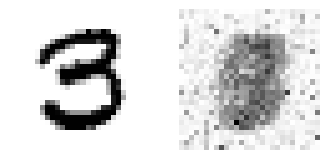

epoch:  14%|█▍        | 28/200 [05:48<35:47, 12.49s/it]


Epoch 028 train_loss: 0.2917 val_loss 0.2853
loss 0.286208838224411


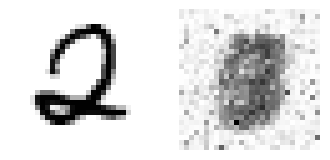

epoch:  14%|█▍        | 29/200 [06:00<35:22, 12.42s/it]


Epoch 029 train_loss: 0.2862 val_loss 0.2807
loss 0.2816857695579529


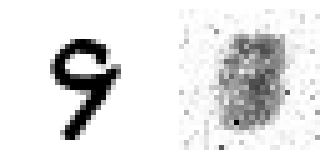

epoch:  15%|█▌        | 30/200 [06:12<35:04, 12.38s/it]


Epoch 030 train_loss: 0.2817 val_loss 0.2770
loss 0.2779732048511505


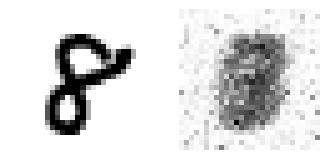

epoch:  16%|█▌        | 31/200 [06:25<35:21, 12.55s/it]


Epoch 031 train_loss: 0.2780 val_loss 0.2740
loss 0.27491337060928345


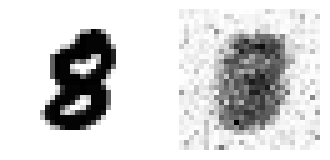

epoch:  16%|█▌        | 32/200 [06:38<35:21, 12.63s/it]


Epoch 032 train_loss: 0.2749 val_loss 0.2714
loss 0.2723480463027954


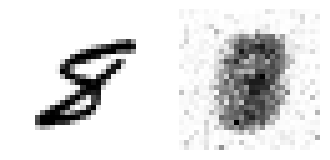

epoch:  16%|█▋        | 33/200 [06:50<35:00, 12.58s/it]


Epoch 033 train_loss: 0.2723 val_loss 0.2692
loss 0.2701181471347809


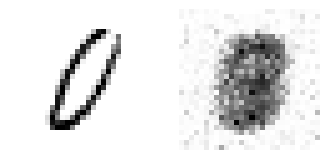

epoch:  17%|█▋        | 34/200 [07:03<34:32, 12.48s/it]


Epoch 034 train_loss: 0.2701 val_loss 0.2672
loss 0.2680913209915161


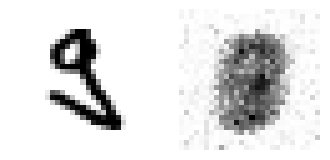

epoch:  18%|█▊        | 35/200 [07:15<34:21, 12.50s/it]


Epoch 035 train_loss: 0.2681 val_loss 0.2653
loss 0.2662002146244049


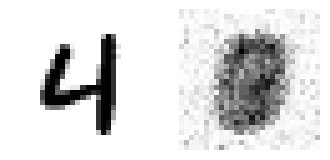

epoch:  18%|█▊        | 36/200 [07:28<34:12, 12.51s/it]


Epoch 036 train_loss: 0.2662 val_loss 0.2636
loss 0.26444634795188904


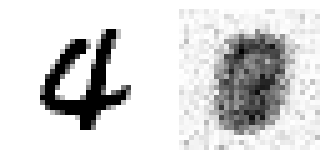

epoch:  18%|█▊        | 37/200 [07:40<33:47, 12.44s/it]


Epoch 037 train_loss: 0.2644 val_loss 0.2620
loss 0.26286202669143677


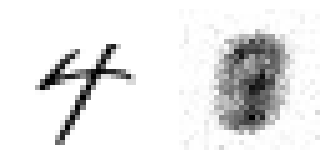

epoch:  19%|█▉        | 38/200 [07:52<33:24, 12.37s/it]


Epoch 038 train_loss: 0.2629 val_loss 0.2606
loss 0.26146596670150757


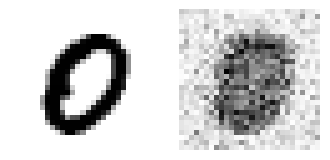

epoch:  20%|█▉        | 39/200 [08:05<33:12, 12.38s/it]


Epoch 039 train_loss: 0.2615 val_loss 0.2594
loss 0.2602410614490509


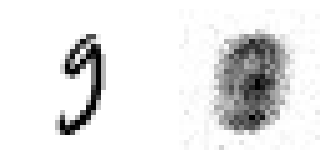

epoch:  20%|██        | 40/200 [08:18<34:03, 12.77s/it]


Epoch 040 train_loss: 0.2602 val_loss 0.2583
loss 0.25914427638053894


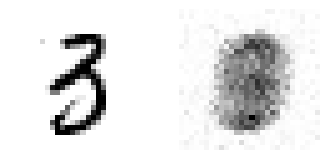

epoch:  20%|██        | 41/200 [08:34<35:47, 13.50s/it]


Epoch 041 train_loss: 0.2591 val_loss 0.2573
loss 0.2581315338611603


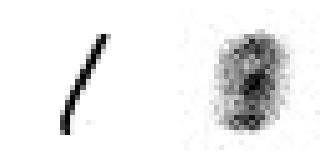

epoch:  21%|██        | 42/200 [08:48<36:27, 13.85s/it]


Epoch 042 train_loss: 0.2581 val_loss 0.2563
loss 0.2571725845336914


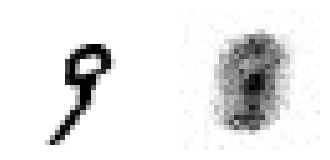

epoch:  22%|██▏       | 43/200 [09:01<35:16, 13.48s/it]


Epoch 043 train_loss: 0.2572 val_loss 0.2554
loss 0.2562515139579773


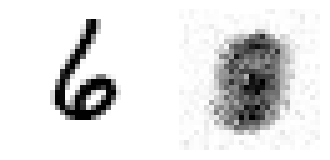

epoch:  22%|██▏       | 44/200 [09:13<34:18, 13.20s/it]


Epoch 044 train_loss: 0.2563 val_loss 0.2545
loss 0.25535932183265686


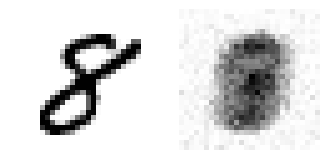

epoch:  22%|██▎       | 45/200 [09:26<33:23, 12.93s/it]


Epoch 045 train_loss: 0.2554 val_loss 0.2537
loss 0.25448888540267944


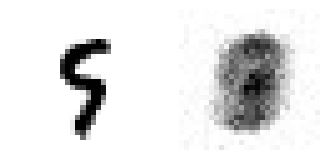

epoch:  23%|██▎       | 46/200 [09:38<32:41, 12.73s/it]


Epoch 046 train_loss: 0.2545 val_loss 0.2528
loss 0.2536310851573944


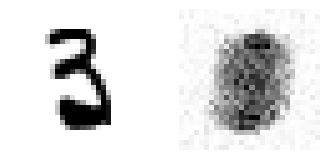

epoch:  24%|██▎       | 47/200 [09:50<32:06, 12.59s/it]


Epoch 047 train_loss: 0.2536 val_loss 0.2519
loss 0.2527751624584198


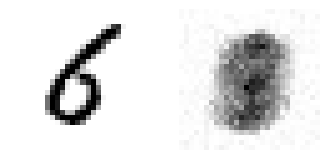

epoch:  24%|██▍       | 48/200 [10:03<31:47, 12.55s/it]


Epoch 048 train_loss: 0.2528 val_loss 0.2511
loss 0.25191059708595276


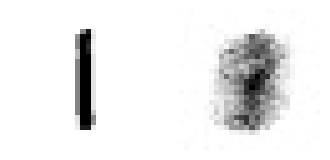

epoch:  24%|██▍       | 49/200 [10:16<31:57, 12.70s/it]


Epoch 049 train_loss: 0.2519 val_loss 0.2502
loss 0.2510325312614441


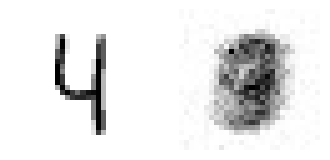

epoch:  25%|██▌       | 50/200 [10:28<31:36, 12.64s/it]


Epoch 050 train_loss: 0.2510 val_loss 0.2493
loss 0.2501412332057953


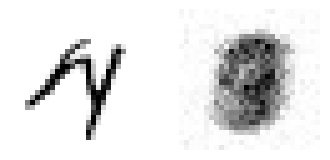

epoch:  26%|██▌       | 51/200 [10:41<31:13, 12.57s/it]


Epoch 051 train_loss: 0.2501 val_loss 0.2484
loss 0.2492363452911377


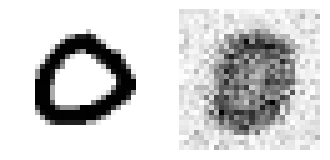

epoch:  26%|██▌       | 52/200 [10:54<31:54, 12.93s/it]


Epoch 052 train_loss: 0.2492 val_loss 0.2475
loss 0.24831555783748627


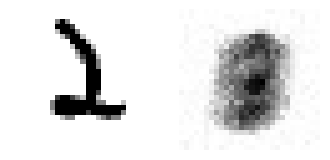

epoch:  26%|██▋       | 53/200 [11:07<31:21, 12.80s/it]


Epoch 053 train_loss: 0.2483 val_loss 0.2465
loss 0.2473773956298828


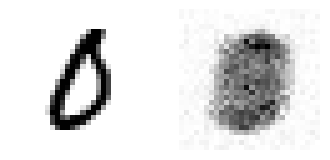

epoch:  27%|██▋       | 54/200 [11:19<30:46, 12.65s/it]


Epoch 054 train_loss: 0.2474 val_loss 0.2456
loss 0.2464207410812378


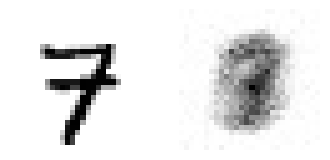

epoch:  28%|██▊       | 55/200 [11:31<30:16, 12.53s/it]


Epoch 055 train_loss: 0.2464 val_loss 0.2446
loss 0.24544520676136017


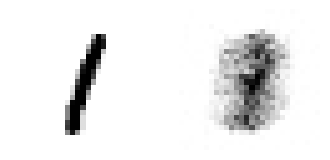

epoch:  28%|██▊       | 56/200 [11:44<29:56, 12.48s/it]


Epoch 056 train_loss: 0.2454 val_loss 0.2436
loss 0.24445387721061707


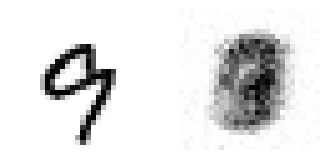

epoch:  28%|██▊       | 57/200 [11:56<29:24, 12.34s/it]


Epoch 057 train_loss: 0.2445 val_loss 0.2426
loss 0.24345239996910095


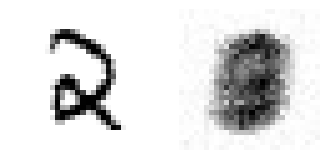

epoch:  29%|██▉       | 58/200 [12:08<29:22, 12.41s/it]


Epoch 058 train_loss: 0.2435 val_loss 0.2416
loss 0.2424435168504715


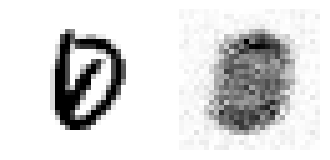

epoch:  30%|██▉       | 59/200 [12:21<29:05, 12.38s/it]


Epoch 059 train_loss: 0.2424 val_loss 0.2406
loss 0.241426020860672


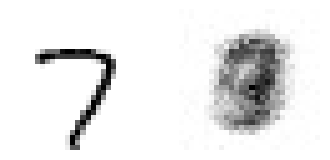

epoch:  30%|███       | 60/200 [12:33<28:57, 12.41s/it]


Epoch 060 train_loss: 0.2414 val_loss 0.2396
loss 0.2403978556394577


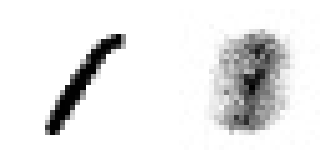

epoch:  30%|███       | 61/200 [12:45<28:37, 12.36s/it]


Epoch 061 train_loss: 0.2404 val_loss 0.2385
loss 0.23935653269290924


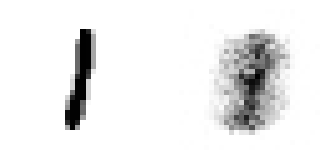

epoch:  31%|███       | 62/200 [12:58<28:24, 12.35s/it]


Epoch 062 train_loss: 0.2394 val_loss 0.2375
loss 0.23829853534698486


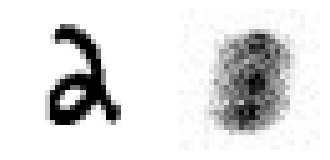

epoch:  32%|███▏      | 63/200 [13:10<28:09, 12.33s/it]


Epoch 063 train_loss: 0.2383 val_loss 0.2364
loss 0.23722213506698608


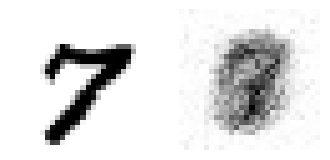

epoch:  32%|███▏      | 64/200 [13:22<27:57, 12.33s/it]


Epoch 064 train_loss: 0.2372 val_loss 0.2353
loss 0.2361266016960144


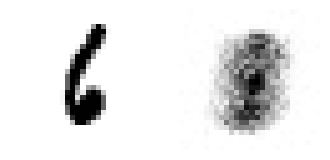

epoch:  32%|███▎      | 65/200 [13:35<27:47, 12.35s/it]


Epoch 065 train_loss: 0.2361 val_loss 0.2342
loss 0.23501086235046387


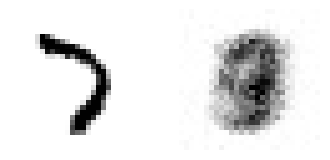

epoch:  33%|███▎      | 66/200 [13:47<27:31, 12.33s/it]


Epoch 066 train_loss: 0.2350 val_loss 0.2331
loss 0.23387490212917328


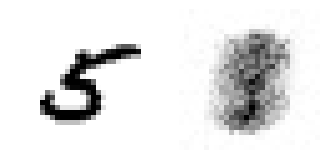

epoch:  34%|███▎      | 67/200 [13:59<27:17, 12.31s/it]


Epoch 067 train_loss: 0.2339 val_loss 0.2320
loss 0.2327205389738083


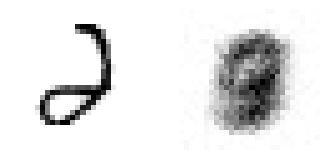

epoch:  34%|███▍      | 68/200 [14:12<27:06, 12.33s/it]


Epoch 068 train_loss: 0.2327 val_loss 0.2308
loss 0.2315504550933838


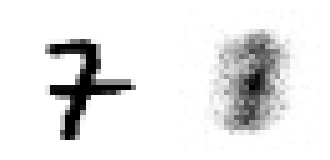

epoch:  34%|███▍      | 69/200 [14:24<26:59, 12.36s/it]


Epoch 069 train_loss: 0.2316 val_loss 0.2296
loss 0.23036831617355347


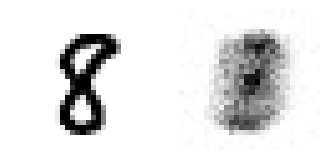

epoch:  35%|███▌      | 70/200 [14:37<26:49, 12.38s/it]


Epoch 070 train_loss: 0.2304 val_loss 0.2285
loss 0.2291778028011322


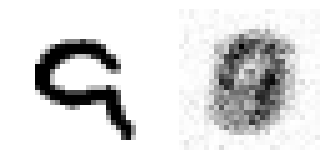

epoch:  36%|███▌      | 71/200 [14:49<26:32, 12.34s/it]


Epoch 071 train_loss: 0.2292 val_loss 0.2273
loss 0.22798091173171997


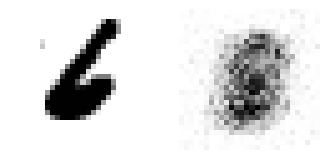

epoch:  36%|███▌      | 72/200 [15:01<26:15, 12.31s/it]


Epoch 072 train_loss: 0.2280 val_loss 0.2261
loss 0.2267778515815735


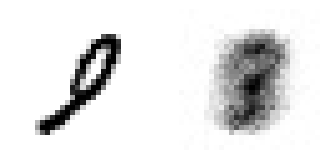

epoch:  36%|███▋      | 73/200 [15:13<26:06, 12.34s/it]


Epoch 073 train_loss: 0.2268 val_loss 0.2249
loss 0.22556933760643005


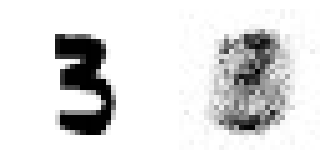

epoch:  37%|███▋      | 74/200 [15:25<25:40, 12.23s/it]


Epoch 074 train_loss: 0.2256 val_loss 0.2237
loss 0.22435468435287476


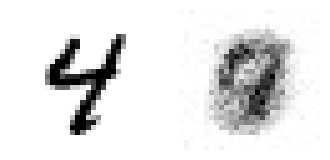

epoch:  38%|███▊      | 75/200 [15:38<25:37, 12.30s/it]


Epoch 075 train_loss: 0.2244 val_loss 0.2225
loss 0.22313229739665985


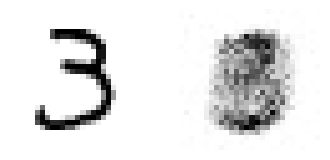

epoch:  38%|███▊      | 76/200 [15:50<25:21, 12.27s/it]


Epoch 076 train_loss: 0.2231 val_loss 0.2212
loss 0.22190147638320923


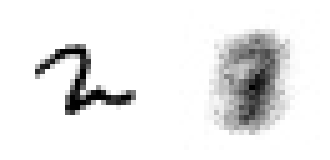

epoch:  38%|███▊      | 77/200 [16:03<25:18, 12.34s/it]


Epoch 077 train_loss: 0.2219 val_loss 0.2200
loss 0.22066229581832886


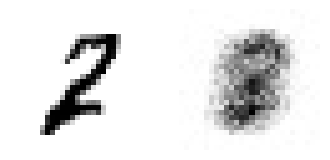

epoch:  39%|███▉      | 78/200 [16:15<25:04, 12.33s/it]


Epoch 078 train_loss: 0.2207 val_loss 0.2188
loss 0.2194143831729889


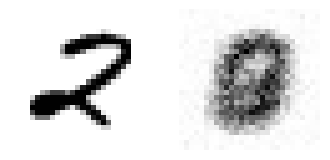

epoch:  40%|███▉      | 79/200 [16:27<24:57, 12.38s/it]


Epoch 079 train_loss: 0.2194 val_loss 0.2175
loss 0.21815836429595947


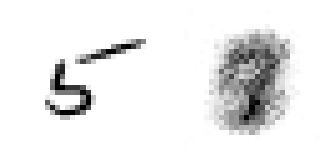

epoch:  40%|████      | 80/200 [16:40<24:46, 12.39s/it]


Epoch 080 train_loss: 0.2182 val_loss 0.2163
loss 0.21689464151859283


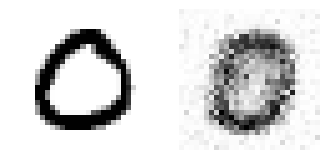

epoch:  40%|████      | 81/200 [16:52<24:35, 12.40s/it]


Epoch 081 train_loss: 0.2169 val_loss 0.2150
loss 0.2156248390674591


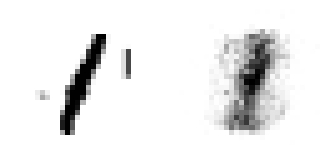

epoch:  41%|████      | 82/200 [17:04<24:16, 12.35s/it]


Epoch 082 train_loss: 0.2156 val_loss 0.2138
loss 0.2143506556749344


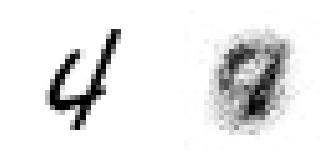

epoch:  42%|████▏     | 83/200 [17:17<23:57, 12.28s/it]


Epoch 083 train_loss: 0.2144 val_loss 0.2125
loss 0.2130727767944336


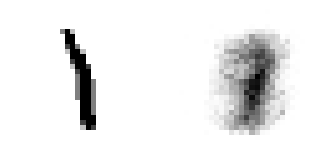

epoch:  42%|████▏     | 84/200 [17:29<23:51, 12.34s/it]


Epoch 084 train_loss: 0.2131 val_loss 0.2112
loss 0.21179012954235077


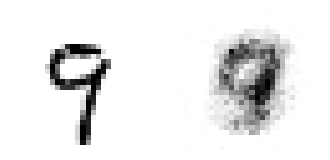

epoch:  42%|████▎     | 85/200 [17:41<23:37, 12.33s/it]


Epoch 085 train_loss: 0.2118 val_loss 0.2100
loss 0.2105005383491516


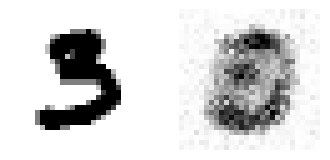

epoch:  43%|████▎     | 86/200 [17:54<23:28, 12.35s/it]


Epoch 086 train_loss: 0.2105 val_loss 0.2087
loss 0.209202378988266


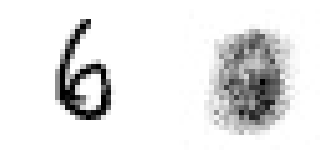

epoch:  44%|████▎     | 87/200 [18:06<23:10, 12.31s/it]


Epoch 087 train_loss: 0.2092 val_loss 0.2074
loss 0.20789410173892975


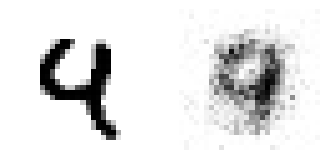

epoch:  44%|████▍     | 88/200 [18:18<22:55, 12.28s/it]


Epoch 088 train_loss: 0.2079 val_loss 0.2061
loss 0.20657522976398468


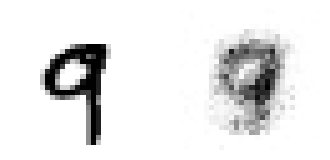

epoch:  44%|████▍     | 89/200 [18:31<22:47, 12.32s/it]


Epoch 089 train_loss: 0.2066 val_loss 0.2047
loss 0.2052454948425293


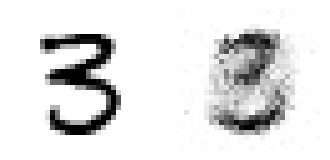

epoch:  45%|████▌     | 90/200 [18:43<22:36, 12.33s/it]


Epoch 090 train_loss: 0.2052 val_loss 0.2034
loss 0.2039041519165039


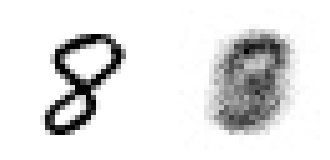

epoch:  46%|████▌     | 91/200 [18:55<22:18, 12.28s/it]


Epoch 091 train_loss: 0.2039 val_loss 0.2021
loss 0.20255060493946075


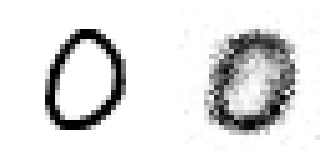

epoch:  46%|████▌     | 92/200 [19:07<22:04, 12.26s/it]


Epoch 092 train_loss: 0.2026 val_loss 0.2007
loss 0.20118598639965057


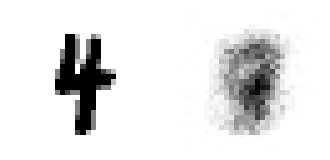

epoch:  46%|████▋     | 93/200 [19:19<21:43, 12.18s/it]


Epoch 093 train_loss: 0.2012 val_loss 0.1993
loss 0.199812114238739


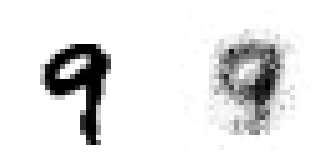

epoch:  47%|████▋     | 94/200 [19:32<21:43, 12.30s/it]


Epoch 094 train_loss: 0.1998 val_loss 0.1980
loss 0.1984308362007141


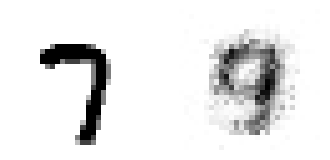

epoch:  48%|████▊     | 95/200 [19:44<21:25, 12.24s/it]


Epoch 095 train_loss: 0.1984 val_loss 0.1966
loss 0.19704356789588928


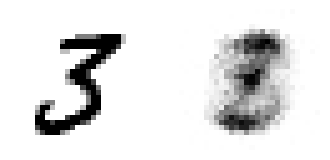

epoch:  48%|████▊     | 96/200 [19:56<21:10, 12.21s/it]


Epoch 096 train_loss: 0.1970 val_loss 0.1952
loss 0.19565236568450928


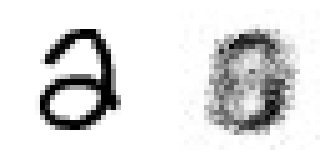

epoch:  48%|████▊     | 97/200 [20:08<20:57, 12.21s/it]


Epoch 097 train_loss: 0.1957 val_loss 0.1938
loss 0.1942598670721054


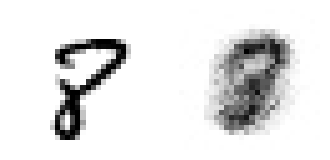

epoch:  49%|████▉     | 98/200 [20:21<20:51, 12.27s/it]


Epoch 098 train_loss: 0.1943 val_loss 0.1924
loss 0.19287140667438507


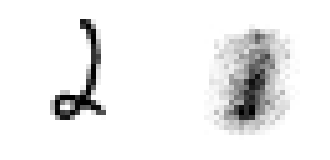

epoch:  50%|████▉     | 99/200 [20:34<20:55, 12.43s/it]


Epoch 099 train_loss: 0.1929 val_loss 0.1911
loss 0.19148917496204376


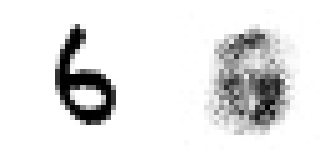

epoch:  50%|█████     | 100/200 [20:46<20:43, 12.43s/it]


Epoch 100 train_loss: 0.1915 val_loss 0.1897
loss 0.1901150494813919


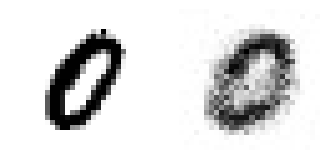

epoch:  50%|█████     | 101/200 [20:58<20:24, 12.37s/it]


Epoch 101 train_loss: 0.1901 val_loss 0.1883
loss 0.18875132501125336


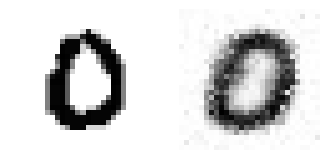

epoch:  51%|█████     | 102/200 [21:11<20:15, 12.40s/it]


Epoch 102 train_loss: 0.1888 val_loss 0.1870
loss 0.18739721179008484


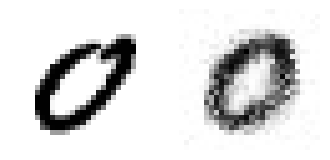

epoch:  52%|█████▏    | 103/200 [21:23<20:01, 12.38s/it]


Epoch 103 train_loss: 0.1874 val_loss 0.1857
loss 0.1860547661781311


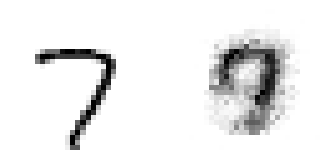

epoch:  52%|█████▏    | 104/200 [21:35<19:45, 12.35s/it]


Epoch 104 train_loss: 0.1861 val_loss 0.1843
loss 0.18472662568092346


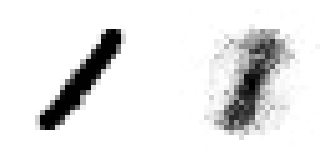

epoch:  52%|█████▎    | 105/200 [21:48<19:32, 12.35s/it]


Epoch 105 train_loss: 0.1847 val_loss 0.1830
loss 0.1834125965833664


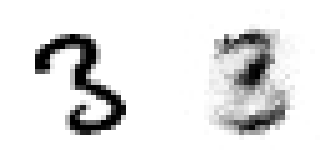

epoch:  53%|█████▎    | 106/200 [22:00<19:20, 12.35s/it]


Epoch 106 train_loss: 0.1834 val_loss 0.1817
loss 0.1821105033159256


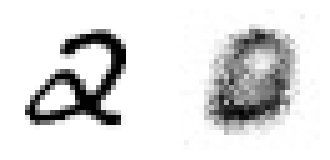

epoch:  54%|█████▎    | 107/200 [22:12<19:12, 12.40s/it]


Epoch 107 train_loss: 0.1821 val_loss 0.1805
loss 0.1808202862739563


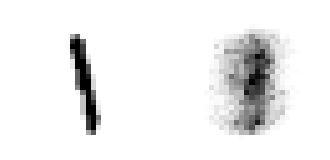

epoch:  54%|█████▍    | 108/200 [22:25<18:56, 12.35s/it]


Epoch 108 train_loss: 0.1808 val_loss 0.1792
loss 0.17954401671886444


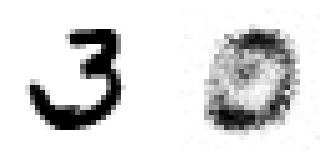

epoch:  55%|█████▍    | 109/200 [22:37<18:41, 12.33s/it]


Epoch 109 train_loss: 0.1795 val_loss 0.1779
loss 0.17828288674354553


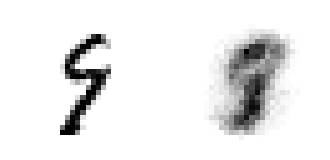

epoch:  55%|█████▌    | 110/200 [22:49<18:27, 12.31s/it]


Epoch 110 train_loss: 0.1783 val_loss 0.1767
loss 0.17703650891780853


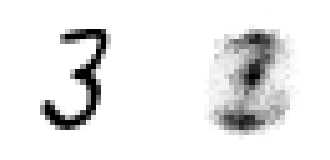

epoch:  56%|█████▌    | 111/200 [23:02<18:18, 12.34s/it]


Epoch 111 train_loss: 0.1770 val_loss 0.1755
loss 0.17580711841583252


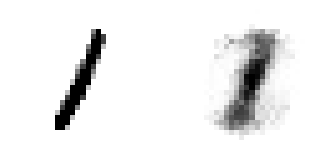

epoch:  56%|█████▌    | 112/200 [23:14<18:05, 12.34s/it]


Epoch 112 train_loss: 0.1758 val_loss 0.1743
loss 0.17459715902805328


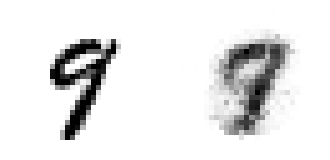

epoch:  56%|█████▋    | 113/200 [23:26<17:52, 12.33s/it]


Epoch 113 train_loss: 0.1746 val_loss 0.1731
loss 0.17340810596942902


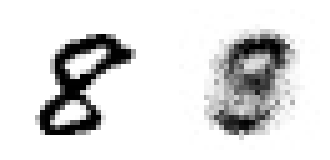

epoch:  57%|█████▋    | 114/200 [23:39<17:53, 12.48s/it]


Epoch 114 train_loss: 0.1734 val_loss 0.1719
loss 0.17224113643169403


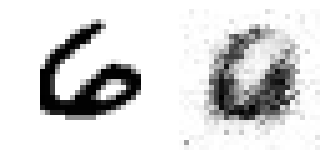

epoch:  57%|█████▊    | 115/200 [23:52<17:44, 12.52s/it]


Epoch 115 train_loss: 0.1722 val_loss 0.1708
loss 0.17109836637973785


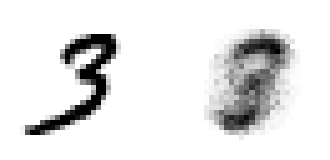

epoch:  58%|█████▊    | 116/200 [24:04<17:23, 12.43s/it]


Epoch 116 train_loss: 0.1711 val_loss 0.1697
loss 0.1699792891740799


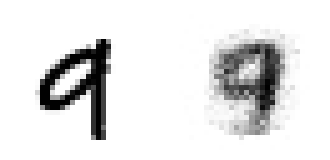

epoch:  58%|█████▊    | 117/200 [24:16<17:05, 12.36s/it]


Epoch 117 train_loss: 0.1700 val_loss 0.1686
loss 0.1688826084136963


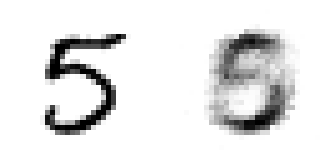

epoch:  59%|█████▉    | 118/200 [24:30<17:23, 12.72s/it]


Epoch 118 train_loss: 0.1689 val_loss 0.1675
loss 0.16781021654605865


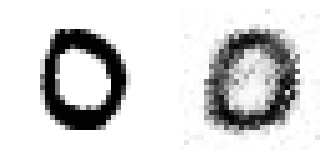

epoch:  60%|█████▉    | 119/200 [24:42<17:04, 12.65s/it]


Epoch 119 train_loss: 0.1678 val_loss 0.1665
loss 0.16676418483257294


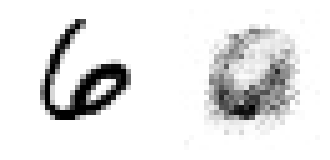

epoch:  60%|██████    | 120/200 [24:55<16:43, 12.55s/it]


Epoch 120 train_loss: 0.1668 val_loss 0.1655
loss 0.16574515402317047


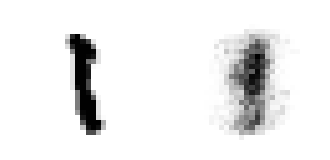

epoch:  60%|██████    | 121/200 [25:07<16:23, 12.45s/it]


Epoch 121 train_loss: 0.1657 val_loss 0.1645
loss 0.1647518277168274


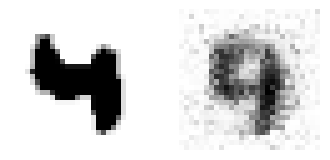

epoch:  61%|██████    | 122/200 [25:19<16:05, 12.38s/it]


Epoch 122 train_loss: 0.1648 val_loss 0.1636
loss 0.16378314793109894


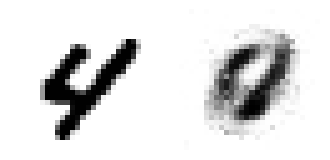

epoch:  62%|██████▏   | 123/200 [25:32<15:58, 12.45s/it]


Epoch 123 train_loss: 0.1638 val_loss 0.1626
loss 0.1628386676311493


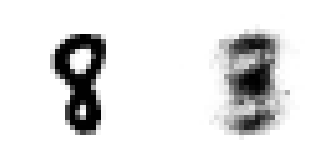

epoch:  62%|██████▏   | 124/200 [25:44<15:44, 12.43s/it]


Epoch 124 train_loss: 0.1628 val_loss 0.1617
loss 0.16191703081130981


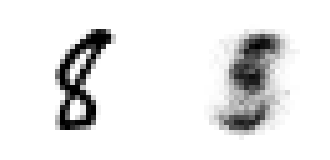

epoch:  62%|██████▎   | 125/200 [25:56<15:30, 12.41s/it]


Epoch 125 train_loss: 0.1619 val_loss 0.1608
loss 0.16101863980293274


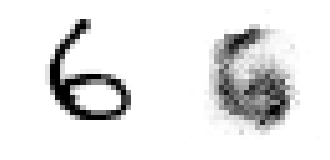

epoch:  63%|██████▎   | 126/200 [26:09<15:13, 12.34s/it]


Epoch 126 train_loss: 0.1610 val_loss 0.1600
loss 0.16014334559440613


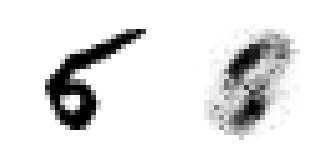

epoch:  64%|██████▎   | 127/200 [26:21<15:04, 12.39s/it]


Epoch 127 train_loss: 0.1601 val_loss 0.1591
loss 0.15929058194160461


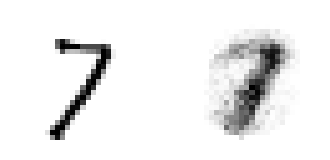

epoch:  64%|██████▍   | 128/200 [26:33<14:51, 12.38s/it]


Epoch 128 train_loss: 0.1593 val_loss 0.1583
loss 0.15846121311187744


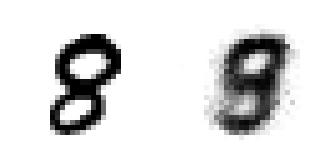

epoch:  64%|██████▍   | 129/200 [26:46<14:36, 12.34s/it]


Epoch 129 train_loss: 0.1585 val_loss 0.1575
loss 0.15765544772148132


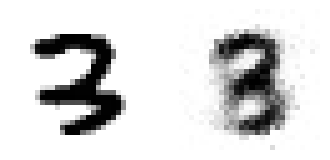

epoch:  65%|██████▌   | 130/200 [26:58<14:21, 12.31s/it]


Epoch 130 train_loss: 0.1577 val_loss 0.1567
loss 0.15687264502048492


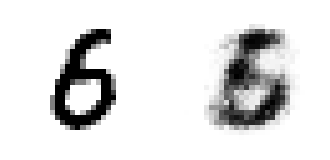

epoch:  66%|██████▌   | 131/200 [27:10<14:07, 12.28s/it]


Epoch 131 train_loss: 0.1569 val_loss 0.1560
loss 0.15611273050308228


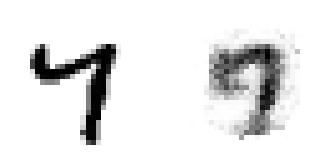

epoch:  66%|██████▌   | 132/200 [27:23<13:59, 12.34s/it]


Epoch 132 train_loss: 0.1561 val_loss 0.1552
loss 0.15537501871585846


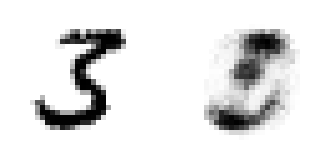

epoch:  66%|██████▋   | 133/200 [27:35<13:48, 12.36s/it]


Epoch 133 train_loss: 0.1554 val_loss 0.1545
loss 0.15465861558914185


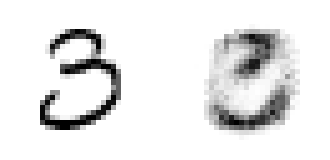

epoch:  67%|██████▋   | 134/200 [27:47<13:33, 12.32s/it]


Epoch 134 train_loss: 0.1547 val_loss 0.1538
loss 0.1539628952741623


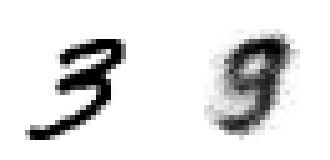

epoch:  68%|██████▊   | 135/200 [27:59<13:18, 12.29s/it]


Epoch 135 train_loss: 0.1540 val_loss 0.1532
loss 0.15328724682331085


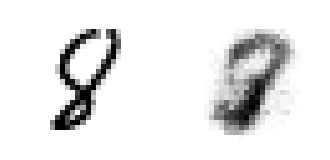

epoch:  68%|██████▊   | 136/200 [28:13<13:40, 12.82s/it]


Epoch 136 train_loss: 0.1533 val_loss 0.1525
loss 0.15263177454471588


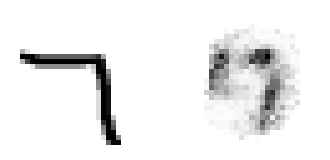

epoch:  68%|██████▊   | 137/200 [28:26<13:17, 12.66s/it]


Epoch 137 train_loss: 0.1526 val_loss 0.1519
loss 0.15200002491474152


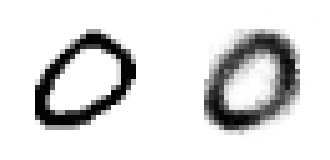

epoch:  69%|██████▉   | 138/200 [28:38<12:59, 12.57s/it]


Epoch 138 train_loss: 0.1520 val_loss 0.1513
loss 0.1514037698507309


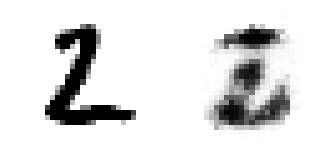

epoch:  70%|██████▉   | 139/200 [28:52<13:02, 12.83s/it]


Epoch 139 train_loss: 0.1514 val_loss 0.1508
loss 0.1508522629737854


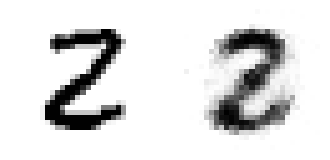

epoch:  70%|███████   | 140/200 [29:05<13:04, 13.07s/it]


Epoch 140 train_loss: 0.1509 val_loss 0.1502
loss 0.15030616521835327


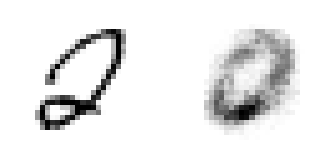

epoch:  70%|███████   | 141/200 [29:17<12:37, 12.84s/it]


Epoch 141 train_loss: 0.1503 val_loss 0.1496
loss 0.14966532588005066


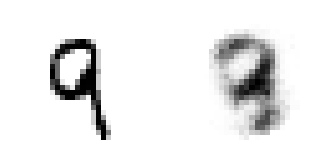

epoch:  71%|███████   | 142/200 [29:30<12:21, 12.79s/it]


Epoch 142 train_loss: 0.1497 val_loss 0.1489
loss 0.14901979267597198


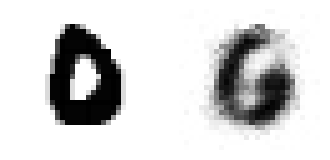

epoch:  72%|███████▏  | 143/200 [29:43<12:04, 12.71s/it]


Epoch 143 train_loss: 0.1490 val_loss 0.1484
loss 0.148505300283432


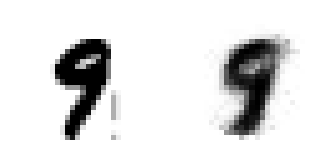

epoch:  72%|███████▏  | 144/200 [29:55<11:48, 12.66s/it]


Epoch 144 train_loss: 0.1485 val_loss 0.1479
loss 0.1480032354593277


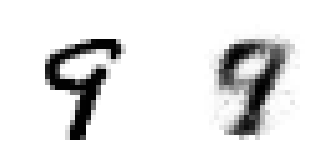

epoch:  72%|███████▎  | 145/200 [30:08<11:32, 12.59s/it]


Epoch 145 train_loss: 0.1480 val_loss 0.1473
loss 0.14740976691246033


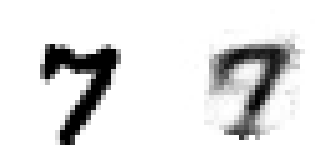

epoch:  73%|███████▎  | 146/200 [30:20<11:15, 12.52s/it]


Epoch 146 train_loss: 0.1474 val_loss 0.1468
loss 0.1468535214662552


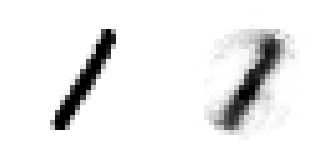

epoch:  74%|███████▎  | 147/200 [30:32<11:00, 12.46s/it]


Epoch 147 train_loss: 0.1469 val_loss 0.1463
loss 0.14637289941310883


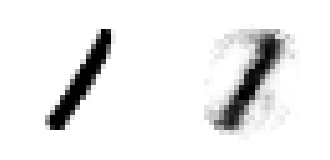

epoch:  74%|███████▍  | 148/200 [30:45<10:48, 12.47s/it]


Epoch 148 train_loss: 0.1464 val_loss 0.1458
loss 0.14584054052829742


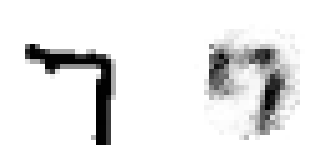

epoch:  74%|███████▍  | 149/200 [30:57<10:33, 12.41s/it]


Epoch 149 train_loss: 0.1458 val_loss 0.1452
loss 0.14528004825115204


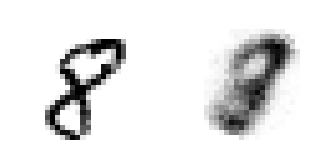

epoch:  75%|███████▌  | 150/200 [31:09<10:18, 12.37s/it]


Epoch 150 train_loss: 0.1453 val_loss 0.1447
loss 0.14478710293769836


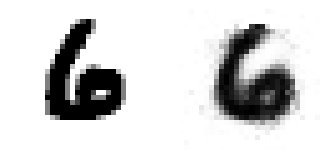

epoch:  76%|███████▌  | 151/200 [31:22<10:03, 12.33s/it]


Epoch 151 train_loss: 0.1448 val_loss 0.1443
loss 0.14429542422294617


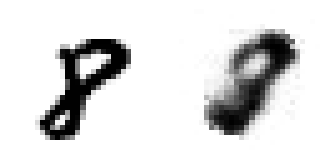

epoch:  76%|███████▌  | 152/200 [31:36<10:17, 12.87s/it]


Epoch 152 train_loss: 0.1443 val_loss 0.1437
loss 0.14375677704811096


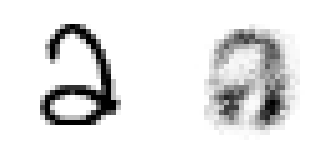

epoch:  76%|███████▋  | 153/200 [31:48<10:00, 12.78s/it]


Epoch 153 train_loss: 0.1438 val_loss 0.1432
loss 0.14324668049812317


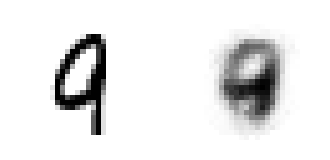

epoch:  77%|███████▋  | 154/200 [32:01<09:41, 12.65s/it]


Epoch 154 train_loss: 0.1432 val_loss 0.1427
loss 0.14276835322380066


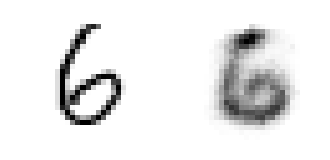

epoch:  78%|███████▊  | 155/200 [32:13<09:22, 12.51s/it]


Epoch 155 train_loss: 0.1428 val_loss 0.1422
loss 0.14225931465625763


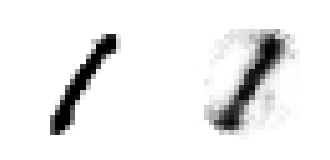

epoch:  78%|███████▊  | 156/200 [32:25<09:06, 12.43s/it]


Epoch 156 train_loss: 0.1423 val_loss 0.1417
loss 0.1417437493801117


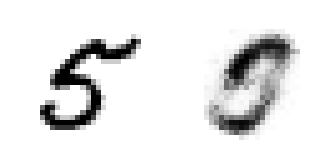

epoch:  78%|███████▊  | 157/200 [32:38<08:55, 12.45s/it]


Epoch 157 train_loss: 0.1417 val_loss 0.1413
loss 0.14126217365264893


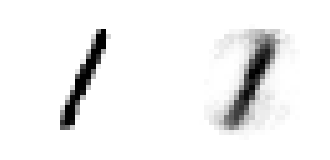

epoch:  79%|███████▉  | 158/200 [32:50<08:40, 12.39s/it]


Epoch 158 train_loss: 0.1413 val_loss 0.1408
loss 0.1407790333032608


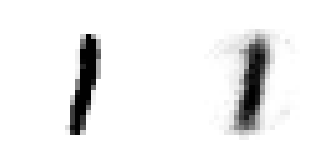

epoch:  80%|███████▉  | 159/200 [33:02<08:25, 12.34s/it]


Epoch 159 train_loss: 0.1408 val_loss 0.1403
loss 0.14027349650859833


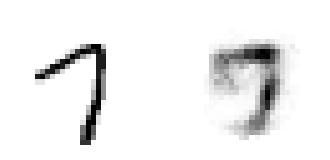

epoch:  80%|████████  | 160/200 [33:14<08:11, 12.29s/it]


Epoch 160 train_loss: 0.1403 val_loss 0.1398
loss 0.13978154957294464


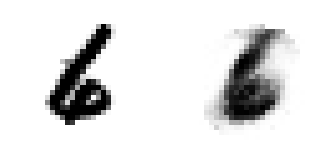

epoch:  80%|████████  | 161/200 [33:27<08:02, 12.38s/it]


Epoch 161 train_loss: 0.1398 val_loss 0.1393
loss 0.13931284844875336


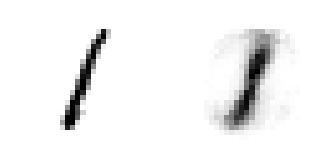

epoch:  81%|████████  | 162/200 [33:39<07:49, 12.36s/it]


Epoch 162 train_loss: 0.1393 val_loss 0.1389
loss 0.13883621990680695


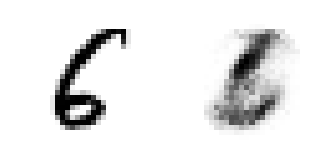

epoch:  82%|████████▏ | 163/200 [33:51<07:36, 12.35s/it]


Epoch 163 train_loss: 0.1388 val_loss 0.1384
loss 0.13834860920906067


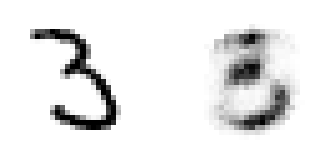

epoch:  82%|████████▏ | 164/200 [34:04<07:26, 12.40s/it]


Epoch 164 train_loss: 0.1383 val_loss 0.1379
loss 0.1378748118877411


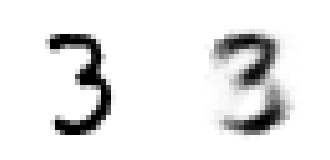

epoch:  82%|████████▎ | 165/200 [34:16<07:15, 12.43s/it]


Epoch 165 train_loss: 0.1379 val_loss 0.1375
loss 0.13741527497768402


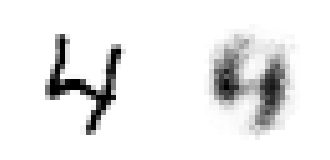

epoch:  83%|████████▎ | 166/200 [34:29<07:02, 12.42s/it]


Epoch 166 train_loss: 0.1374 val_loss 0.1370
loss 0.13695137202739716


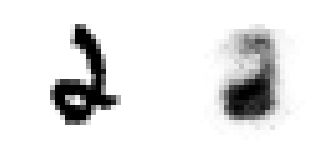

epoch:  84%|████████▎ | 167/200 [34:41<06:48, 12.37s/it]


Epoch 167 train_loss: 0.1370 val_loss 0.1366
loss 0.13648302853107452


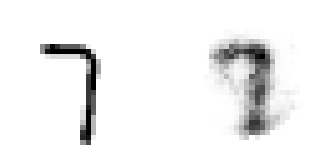

epoch:  84%|████████▍ | 168/200 [34:53<06:35, 12.35s/it]


Epoch 168 train_loss: 0.1365 val_loss 0.1361
loss 0.13602398335933685


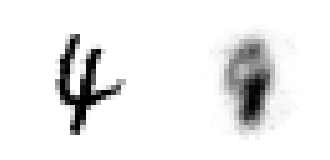

epoch:  84%|████████▍ | 169/200 [35:06<06:22, 12.35s/it]


Epoch 169 train_loss: 0.1360 val_loss 0.1357
loss 0.13557535409927368


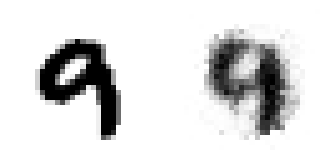

epoch:  85%|████████▌ | 170/200 [35:18<06:08, 12.27s/it]


Epoch 170 train_loss: 0.1356 val_loss 0.1352
loss 0.13512837886810303


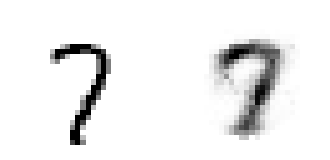

epoch:  86%|████████▌ | 171/200 [35:30<05:54, 12.23s/it]


Epoch 171 train_loss: 0.1351 val_loss 0.1348
loss 0.13468100130558014


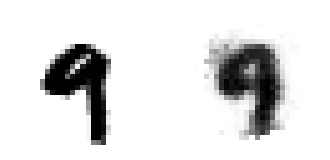

epoch:  86%|████████▌ | 172/200 [35:42<05:41, 12.21s/it]


Epoch 172 train_loss: 0.1347 val_loss 0.1343
loss 0.1342378854751587


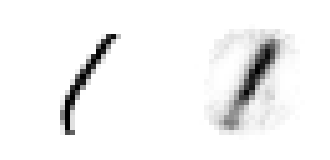

epoch:  86%|████████▋ | 173/200 [35:54<05:29, 12.21s/it]


Epoch 173 train_loss: 0.1342 val_loss 0.1339
loss 0.1338001787662506


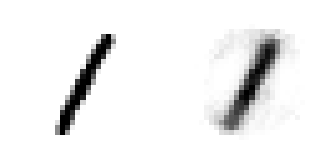

epoch:  87%|████████▋ | 174/200 [36:07<05:19, 12.29s/it]


Epoch 174 train_loss: 0.1338 val_loss 0.1335
loss 0.13336491584777832


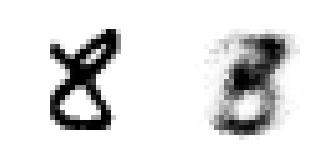

epoch:  88%|████████▊ | 175/200 [36:19<05:06, 12.26s/it]


Epoch 175 train_loss: 0.1334 val_loss 0.1330
loss 0.1329321265220642


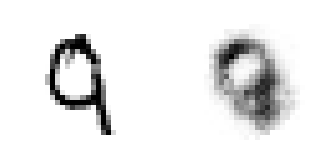

epoch:  88%|████████▊ | 176/200 [36:31<04:54, 12.25s/it]


Epoch 176 train_loss: 0.1329 val_loss 0.1326
loss 0.13250529766082764


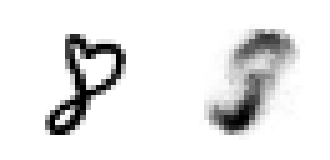

epoch:  88%|████████▊ | 177/200 [36:44<04:41, 12.25s/it]


Epoch 177 train_loss: 0.1325 val_loss 0.1322
loss 0.13208556175231934


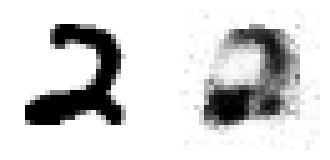

epoch:  89%|████████▉ | 178/200 [36:56<04:30, 12.31s/it]


Epoch 178 train_loss: 0.1321 val_loss 0.1318
loss 0.13167046010494232


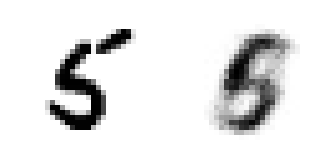

epoch:  90%|████████▉ | 179/200 [37:08<04:18, 12.29s/it]


Epoch 179 train_loss: 0.1317 val_loss 0.1314
loss 0.13125775754451752


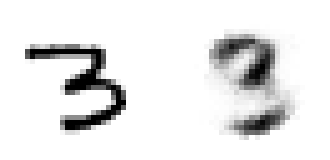

epoch:  90%|█████████ | 180/200 [37:21<04:07, 12.35s/it]


Epoch 180 train_loss: 0.1313 val_loss 0.1310
loss 0.1308487206697464


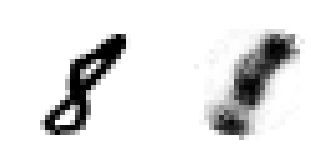

epoch:  90%|█████████ | 181/200 [37:33<03:54, 12.32s/it]


Epoch 181 train_loss: 0.1308 val_loss 0.1306
loss 0.13044582307338715


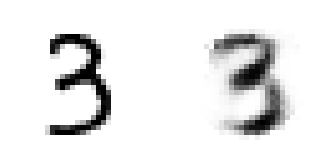

epoch:  91%|█████████ | 182/200 [37:45<03:42, 12.35s/it]


Epoch 182 train_loss: 0.1304 val_loss 0.1302
loss 0.13005073368549347


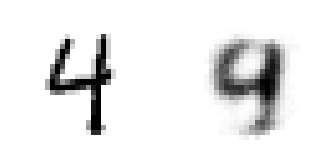

epoch:  92%|█████████▏| 183/200 [37:58<03:29, 12.31s/it]


Epoch 183 train_loss: 0.1301 val_loss 0.1298
loss 0.12966276705265045


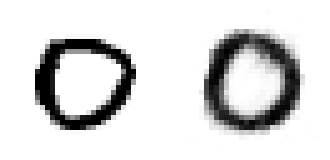

epoch:  92%|█████████▏| 184/200 [38:10<03:16, 12.28s/it]


Epoch 184 train_loss: 0.1297 val_loss 0.1294
loss 0.129281684756279


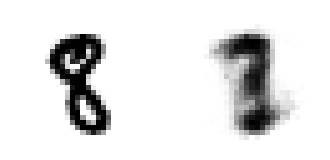

epoch:  92%|█████████▎| 185/200 [38:22<03:04, 12.27s/it]


Epoch 185 train_loss: 0.1293 val_loss 0.1291
loss 0.1289084553718567


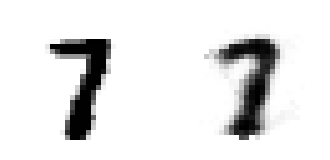

epoch:  93%|█████████▎| 186/200 [38:35<02:52, 12.35s/it]


Epoch 186 train_loss: 0.1289 val_loss 0.1287
loss 0.12854699790477753


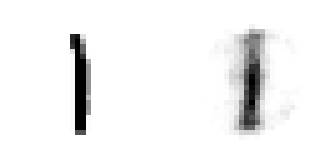

epoch:  94%|█████████▎| 187/200 [38:47<02:39, 12.30s/it]


Epoch 187 train_loss: 0.1285 val_loss 0.1284
loss 0.12820224463939667


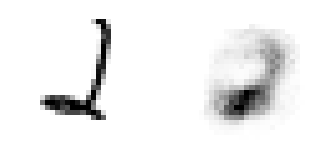

epoch:  94%|█████████▍| 188/200 [38:59<02:27, 12.26s/it]


Epoch 188 train_loss: 0.1282 val_loss 0.1280
loss 0.12787829339504242


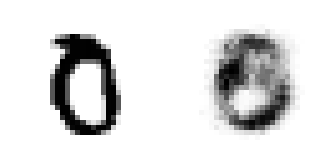

epoch:  94%|█████████▍| 189/200 [39:11<02:14, 12.23s/it]


Epoch 189 train_loss: 0.1279 val_loss 0.1277
loss 0.12756195664405823


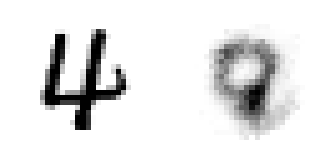

epoch:  95%|█████████▌| 190/200 [39:23<02:02, 12.27s/it]


Epoch 190 train_loss: 0.1276 val_loss 0.1274
loss 0.12723009288311005


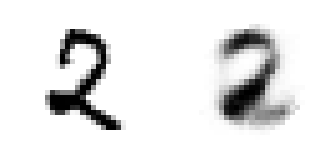

epoch:  96%|█████████▌| 191/200 [39:36<01:50, 12.24s/it]


Epoch 191 train_loss: 0.1272 val_loss 0.1270
loss 0.12685613334178925


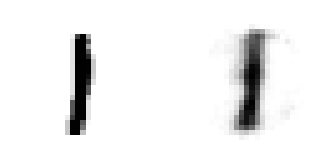

epoch:  96%|█████████▌| 192/200 [39:48<01:38, 12.32s/it]


Epoch 192 train_loss: 0.1269 val_loss 0.1266
loss 0.12647829949855804


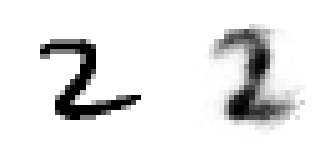

epoch:  96%|█████████▋| 193/200 [40:00<01:26, 12.30s/it]


Epoch 193 train_loss: 0.1265 val_loss 0.1263
loss 0.12614069879055023


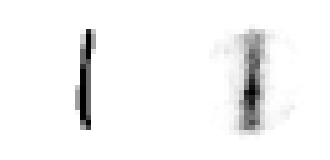

epoch:  97%|█████████▋| 194/200 [40:13<01:13, 12.32s/it]


Epoch 194 train_loss: 0.1261 val_loss 0.1260
loss 0.1258448362350464


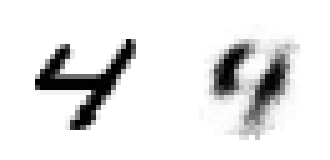

epoch:  98%|█████████▊| 195/200 [40:28<01:05, 13.06s/it]


Epoch 195 train_loss: 0.1258 val_loss 0.1257
loss 0.12555712461471558


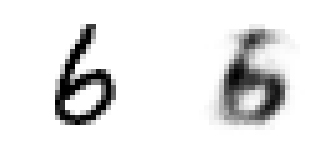

epoch:  98%|█████████▊| 196/200 [40:40<00:51, 12.96s/it]


Epoch 196 train_loss: 0.1256 val_loss 0.1254
loss 0.1252540647983551


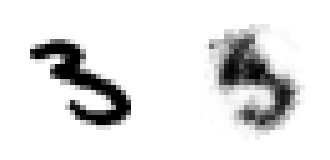

epoch:  98%|█████████▊| 197/200 [40:53<00:38, 12.76s/it]


Epoch 197 train_loss: 0.1253 val_loss 0.1251
loss 0.12494383752346039


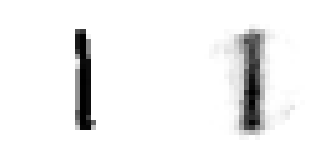

epoch:  99%|█████████▉| 198/200 [41:05<00:25, 12.61s/it]


Epoch 198 train_loss: 0.1249 val_loss 0.1248
loss 0.12464042007923126


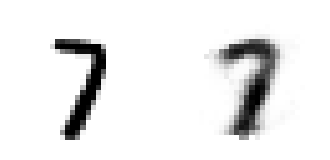

epoch: 100%|█████████▉| 199/200 [41:17<00:12, 12.54s/it]


Epoch 199 train_loss: 0.1246 val_loss 0.1245
loss 0.12434563785791397


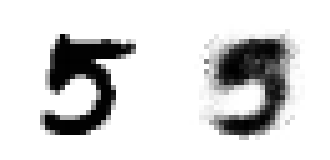

epoch: 100%|██████████| 200/200 [41:29<00:00, 12.45s/it]


Epoch 200 train_loss: 0.1243 val_loss 0.1242


In [52]:
history = train(train_dataset, val_dataset, model=model, epochs=200, batch_size=128, is_cvae=False)

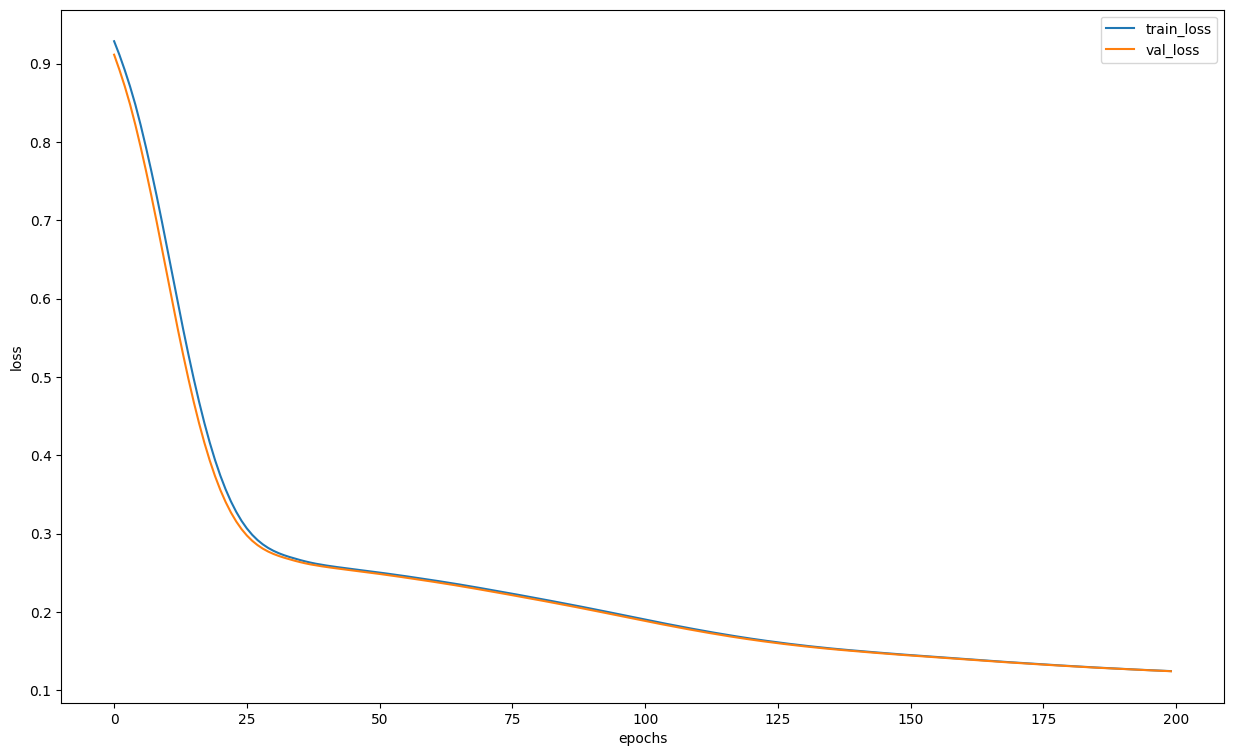

In [53]:
plot_loss(history)

# Sampling

Now we can try to get not the random pictures, but the numbers we want to generate. Let's say numbers from 0 to 9.

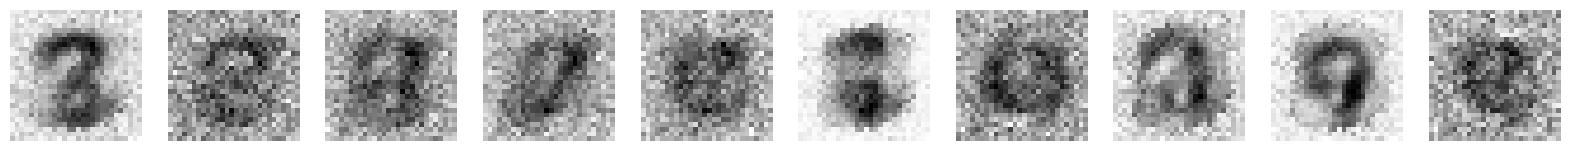

In [54]:
with torch.set_grad_enabled(False):
    number_for_generation=[0,1,2,3,4,5,6,7,8,9]
    inputs = torch.FloatTensor(np.random.randn(10*28*28).reshape(-1,28,28))
    inputs = inputs.to(DEVICE)
    label = one_hot(number_for_generation,9).to(DEVICE)
    outputs = model(inputs,label)
    plot_gallery(outputs.cpu(),28,28,1,10)

# Exploring the latent space using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. Let's use it and plot the results.

In [55]:
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = DataLoader(dataset, batch_size=100, shuffle=True)
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,9).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels

def plot_tsne(net, mode, count, is_cvae=False):
    img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2,random_state=42).fit_transform(latent_vectors)
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

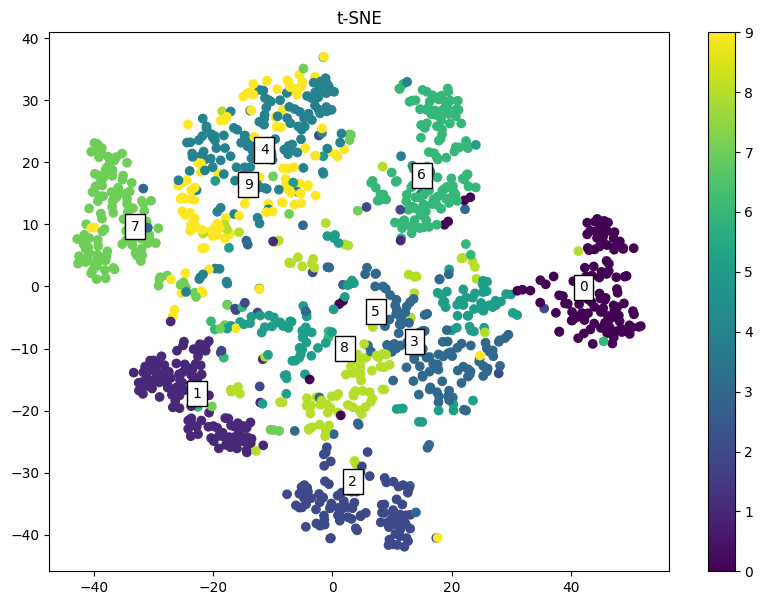

In [56]:
plot_tsne(net=model, mode='dots', count=1000)

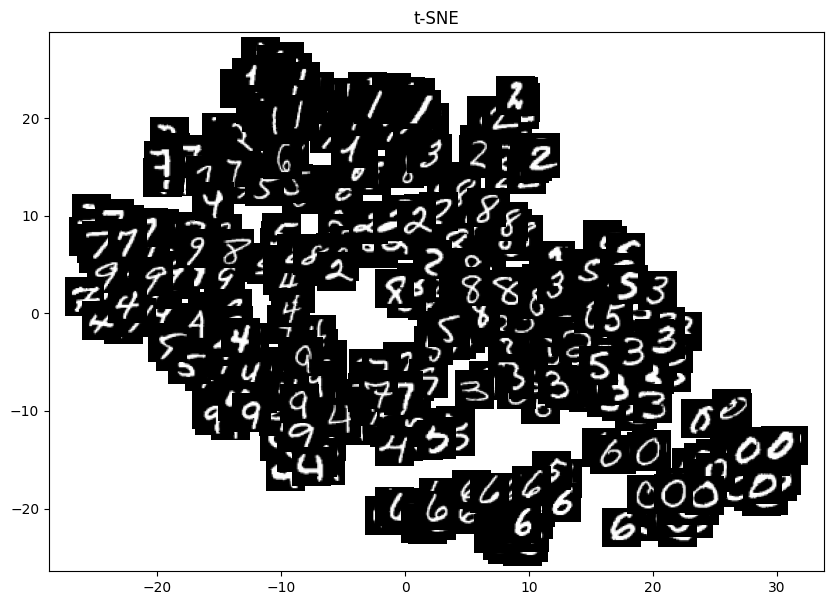

In [57]:
plot_tsne(net=model, mode='imgs', count=300)

# Conditional Variational Autoencoder

In [58]:
class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size=20):
        super(CVAE, self).__init__()
        input_size_with_label = input_size + labels_length
        hidden_size += labels_length
        
        self.fc1 = nn.Linear(input_size_with_label,512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z, labels):
        torch.cat((z, labels), 1)
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        #targets = one_hot(targets,labels_length-1).float().to(DEVICE)
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z, labels)
        return x, mu, logvar

def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=20):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,9).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), 28*28)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

In [59]:
cvae = CVAE(28*28).to(DEVICE)

In [60]:
def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def evaluate(losses, autoencoder, dataloader, flatten=True):
    model = lambda x, y: autoencoder(x, y)[0]    
    loss_sum = []
    inp, out = [],[]
    loss_fn = nn.MSELoss()
    for inputs, labels in dataloader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        if flatten:
            inputs = inputs.view(inputs.size(0), 28*28)

        outputs = model(inputs, labels)
        loss = loss_fn(inputs, outputs)            
        loss_sum.append(loss)
        inp = inputs
        out = outputs

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].detach().cpu(),out[0].detach().cpu()],28,28,1,2)    

    losses.append((sum(loss_sum)/len(loss_sum)).item())

In [61]:
def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=50):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,9).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), 28*28)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

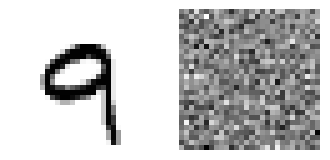

epoch:   2%|▏         | 1/50 [00:14<11:51, 14.53s/it]


Epoch 001 val_loss 1.8126


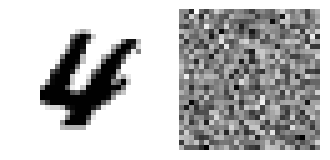

epoch:   4%|▍         | 2/50 [00:29<11:38, 14.56s/it]


Epoch 002 val_loss 1.6351


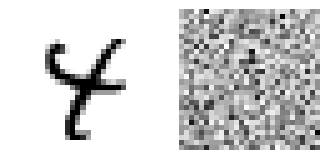

epoch:   6%|▌         | 3/50 [00:41<10:40, 13.64s/it]


Epoch 003 val_loss 1.3833


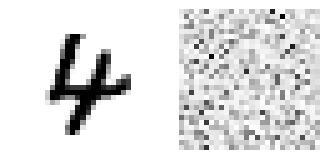

epoch:   8%|▊         | 4/50 [00:53<10:00, 13.05s/it]


Epoch 004 val_loss 1.1355


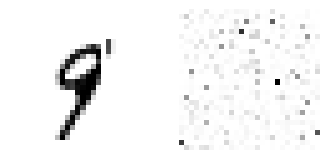

epoch:  10%|█         | 5/50 [01:05<09:32, 12.73s/it]


Epoch 005 val_loss 0.9857


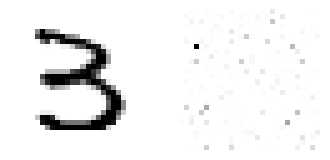

epoch:  12%|█▏        | 6/50 [01:18<09:15, 12.64s/it]


Epoch 006 val_loss 0.9351


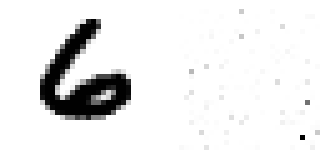

epoch:  14%|█▍        | 7/50 [01:30<09:02, 12.61s/it]


Epoch 007 val_loss 0.9265


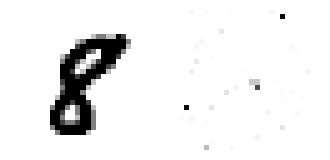

epoch:  16%|█▌        | 8/50 [01:43<08:46, 12.52s/it]


Epoch 008 val_loss 0.9257


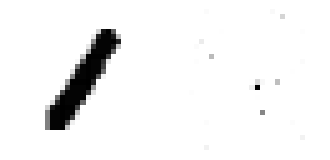

epoch:  18%|█▊        | 9/50 [01:55<08:29, 12.43s/it]


Epoch 009 val_loss 0.9255


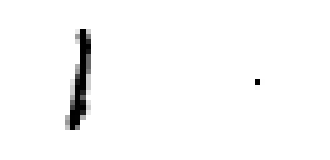

epoch:  20%|██        | 10/50 [02:07<08:15, 12.38s/it]


Epoch 010 val_loss 0.9255


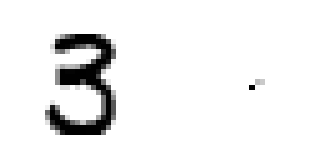

epoch:  22%|██▏       | 11/50 [02:20<08:01, 12.35s/it]


Epoch 011 val_loss 0.9255


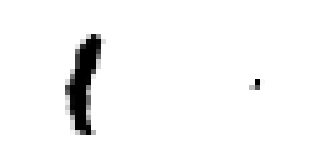

epoch:  24%|██▍       | 12/50 [02:32<07:49, 12.37s/it]


Epoch 012 val_loss 0.9255


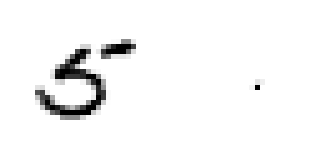

epoch:  26%|██▌       | 13/50 [02:44<07:36, 12.34s/it]


Epoch 013 val_loss 0.9255


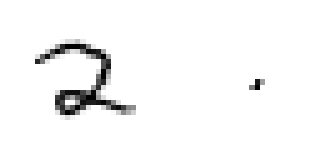

epoch:  28%|██▊       | 14/50 [02:57<07:24, 12.34s/it]


Epoch 014 val_loss 0.9260


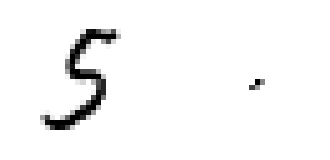

epoch:  30%|███       | 15/50 [03:09<07:10, 12.31s/it]


Epoch 015 val_loss 0.9260


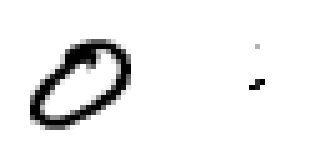

epoch:  32%|███▏      | 16/50 [03:21<06:59, 12.34s/it]


Epoch 016 val_loss 0.9256


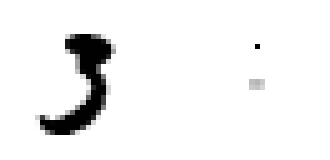

epoch:  34%|███▍      | 17/50 [03:33<06:45, 12.29s/it]


Epoch 017 val_loss 0.9257


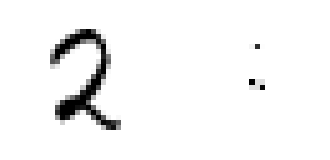

epoch:  36%|███▌      | 18/50 [03:46<06:33, 12.29s/it]


Epoch 018 val_loss 0.9257


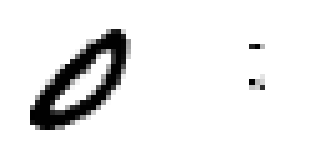

epoch:  38%|███▊      | 19/50 [03:58<06:20, 12.27s/it]


Epoch 019 val_loss 0.9256


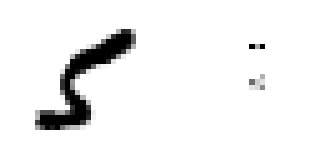

epoch:  40%|████      | 20/50 [04:10<06:09, 12.33s/it]


Epoch 020 val_loss 0.9256


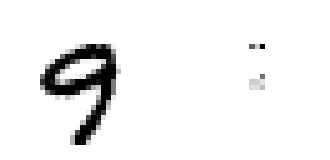

epoch:  42%|████▏     | 21/50 [04:23<05:56, 12.30s/it]


Epoch 021 val_loss 0.9256


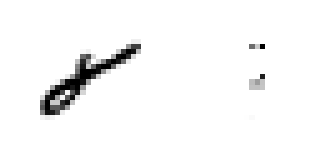

epoch:  44%|████▍     | 22/50 [04:35<05:43, 12.28s/it]


Epoch 022 val_loss 0.9255


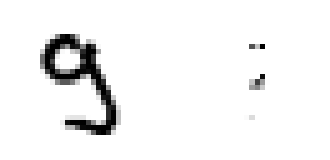

epoch:  46%|████▌     | 23/50 [04:47<05:30, 12.25s/it]


Epoch 023 val_loss 0.9255


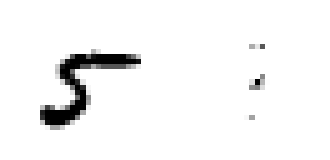

epoch:  48%|████▊     | 24/50 [05:00<05:20, 12.32s/it]


Epoch 024 val_loss 0.9255


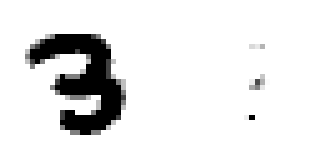

epoch:  50%|█████     | 25/50 [05:12<05:10, 12.40s/it]


Epoch 025 val_loss 0.9255


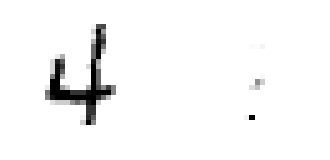

epoch:  52%|█████▏    | 26/50 [05:25<04:57, 12.39s/it]


Epoch 026 val_loss 0.9255


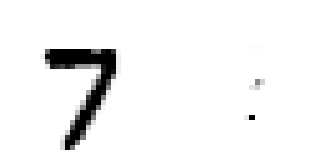

epoch:  54%|█████▍    | 27/50 [05:37<04:44, 12.36s/it]


Epoch 027 val_loss 0.9255


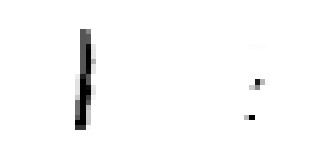

epoch:  56%|█████▌    | 28/50 [05:49<04:33, 12.44s/it]


Epoch 028 val_loss 0.9255


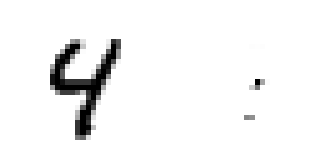

epoch:  58%|█████▊    | 29/50 [06:02<04:20, 12.39s/it]


Epoch 029 val_loss 0.9255


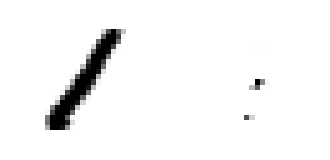

epoch:  60%|██████    | 30/50 [06:14<04:06, 12.34s/it]


Epoch 030 val_loss 0.9255


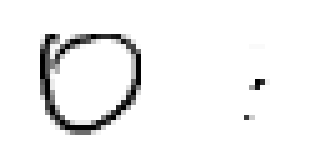

epoch:  62%|██████▏   | 31/50 [06:26<03:53, 12.30s/it]


Epoch 031 val_loss 0.9255


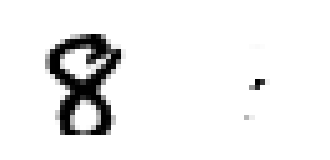

epoch:  64%|██████▍   | 32/50 [06:38<03:41, 12.29s/it]


Epoch 032 val_loss 0.9255


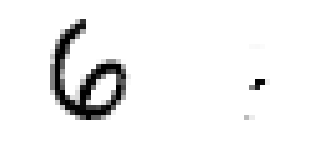

epoch:  66%|██████▌   | 33/50 [06:51<03:30, 12.37s/it]


Epoch 033 val_loss 0.9255


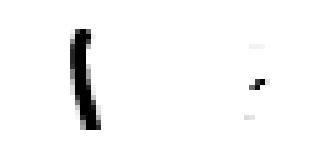

epoch:  68%|██████▊   | 34/50 [07:03<03:17, 12.33s/it]


Epoch 034 val_loss 0.9255


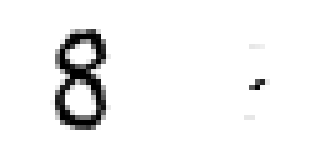

epoch:  70%|███████   | 35/50 [07:15<03:04, 12.31s/it]


Epoch 035 val_loss 0.9255


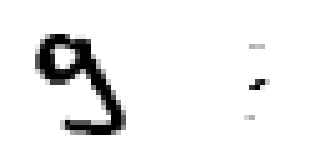

epoch:  72%|███████▏  | 36/50 [07:28<02:52, 12.32s/it]


Epoch 036 val_loss 0.9255


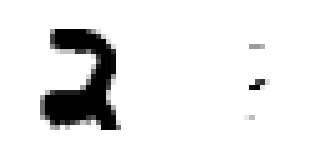

epoch:  74%|███████▍  | 37/50 [07:43<02:49, 13.06s/it]


Epoch 037 val_loss 0.9255


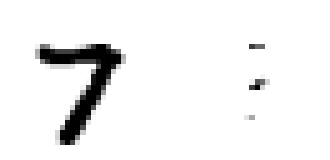

epoch:  76%|███████▌  | 38/50 [07:55<02:34, 12.84s/it]


Epoch 038 val_loss 0.9255


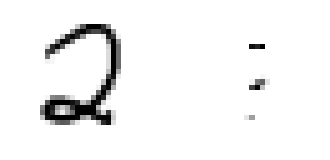

epoch:  78%|███████▊  | 39/50 [08:07<02:19, 12.67s/it]


Epoch 039 val_loss 0.9255


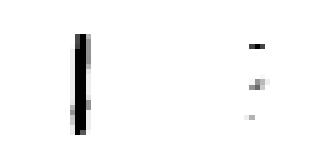

epoch:  80%|████████  | 40/50 [08:19<02:05, 12.52s/it]


Epoch 040 val_loss 0.9255


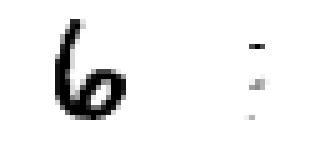

epoch:  82%|████████▏ | 41/50 [08:32<01:52, 12.47s/it]


Epoch 041 val_loss 0.9255


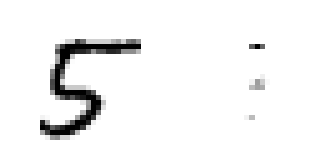

epoch:  84%|████████▍ | 42/50 [08:44<01:39, 12.47s/it]


Epoch 042 val_loss 0.9255


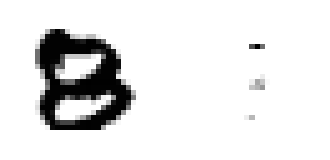

epoch:  86%|████████▌ | 43/50 [08:57<01:27, 12.47s/it]


Epoch 043 val_loss 0.9255


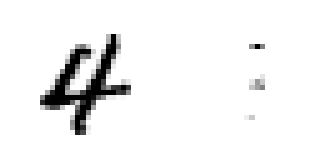

epoch:  88%|████████▊ | 44/50 [09:09<01:14, 12.39s/it]


Epoch 044 val_loss 0.9255


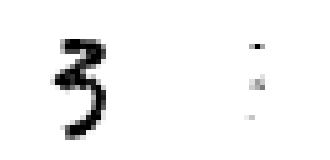

epoch:  90%|█████████ | 45/50 [09:21<01:02, 12.42s/it]


Epoch 045 val_loss 0.9255


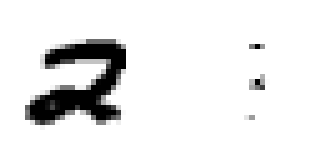

epoch:  92%|█████████▏| 46/50 [09:34<00:49, 12.38s/it]


Epoch 046 val_loss 0.9255


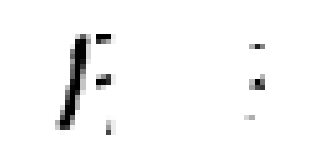

epoch:  94%|█████████▍| 47/50 [09:46<00:36, 12.33s/it]


Epoch 047 val_loss 0.9255


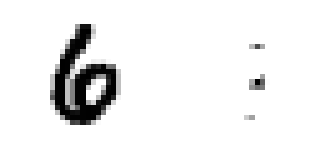

epoch:  96%|█████████▌| 48/50 [09:58<00:24, 12.29s/it]


Epoch 048 val_loss 0.9255


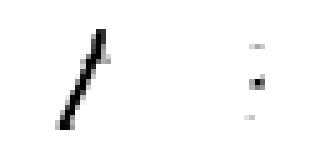

epoch:  98%|█████████▊| 49/50 [10:11<00:12, 12.36s/it]


Epoch 049 val_loss 0.9254


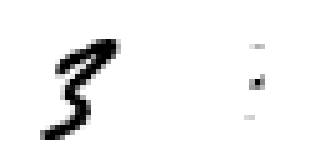

epoch: 100%|██████████| 50/50 [10:23<00:00, 12.47s/it]


Epoch 050 val_loss 0.9254


In [62]:
history = train_cvae(cvae, train_dataset, val_dataset)

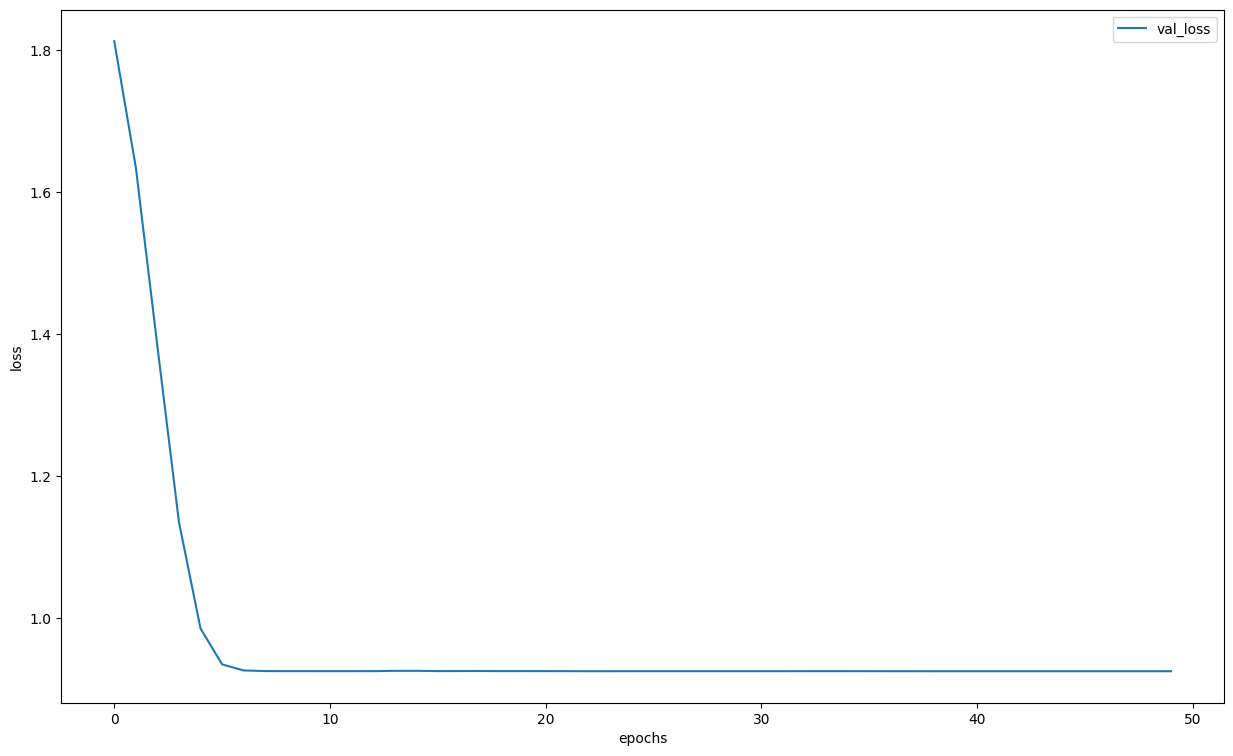

In [63]:
val_loss = history
plt.figure(figsize=(15, 9))
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Plotting CVAE latent space using t-SNE

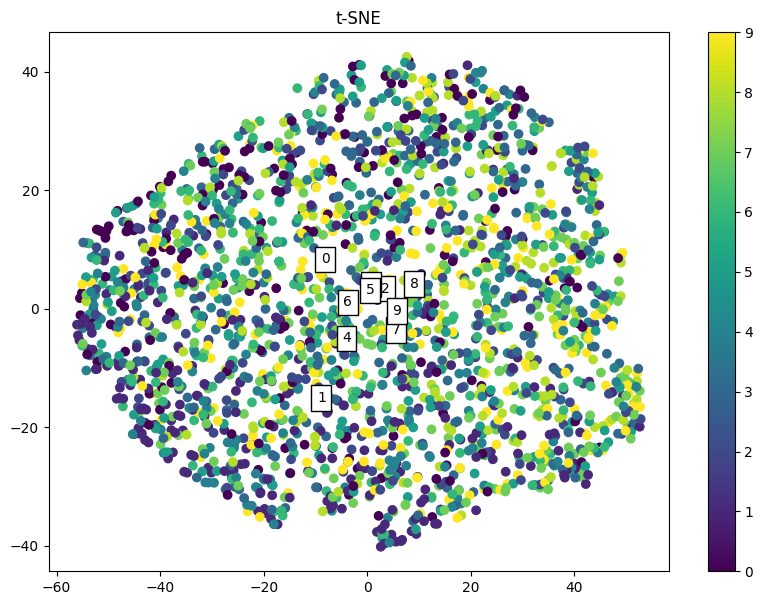

In [64]:
plot_tsne(net=cvae, mode='dots', count=2000, is_cvae=True)

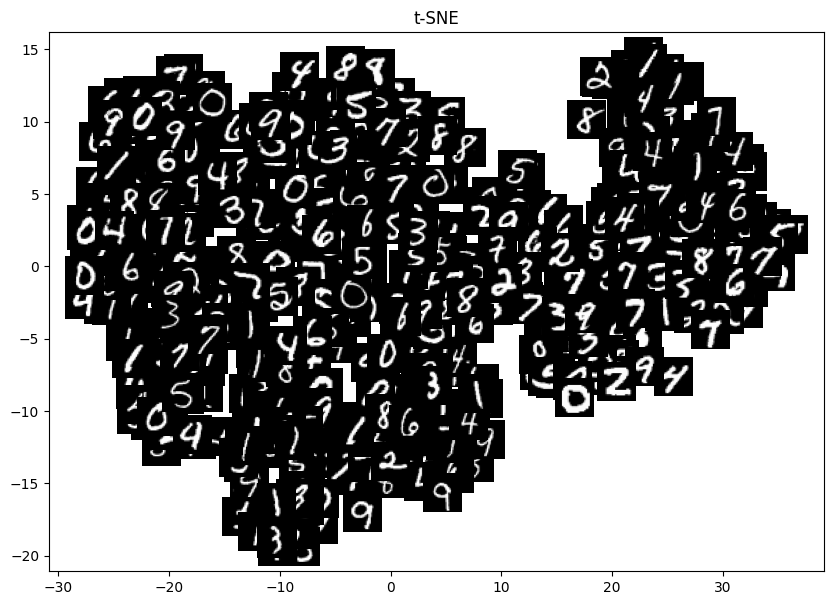

In [65]:
plot_tsne(net=cvae, mode='imgs', count=300, is_cvae=True)

# Conclusion

Optimizing both **reconstruction** loss and **KL divergence** loss together results in the generation of a latent space which maintains the similarity of nearby encodings on the local scale via clustering, yet globally, is very densely packed near the latent space origin (compare the axes with the original).

Cool pic:

![https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif](https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif)